Solar Panels 

In [ ]:
# ===========================
# import necessary Libraries
# ===========================

import sys, os, glob, gc
import joblib
import pandas as pd
import types
import numpy as np
from datetime import datetime
from helper import fill_missing_values, drop_missing_values, plot_outliers




In [2]:
# ====== patch for compatibility with old pandas version ======
def patch_pandas_index_compat():
    import pandas as _pd
    import types as _types
    numeric = _types.ModuleType("pandas.core.indexes.numeric")
    class Int64Index(_pd.Index):
        def __new__(cls, data=None, dtype=None, copy=False, name=None):
            return _pd.Index(data, dtype="int64", copy=copy, name=name)
    numeric.Int64Index = Int64Index
    numeric.RangeIndex = _pd.RangeIndex
    sys.modules['pandas.core.indexes.numeric'] = numeric

    dat = _types.ModuleType("pandas.core.indexes.datetimes")
    dat.DatetimeIndex = _pd.DatetimeIndex
    sys.modules['pandas.core.indexes.datetimes'] = dat

    tdel = _types.ModuleType("pandas.core.indexes.timedeltas")
    tdel.TimedeltaIndex = _pd.TimedeltaIndex
    sys.modules['pandas.core.indexes.timedeltas'] = tdel

patch_pandas_index_compat()


In [3]:
# ===============================================================
# ☀️ Merge all .pkl files and split the data by SEASONS automatically
# 📦 Combine all .pkl files, standardize columns, split by season, and save as separate .h5 files
# ===============================================================

import os, pandas as pd, joblib, glob, gc, re

DATA_DIR = os.path.expanduser("~/Desktop/Solar_Panels2/Data")
store_path = os.path.join(DATA_DIR, "all_data.h5")

# 🧹 Safely close if already open
try:
    pd.io.pytables.close_store(store_path)
except Exception:
    pass

# 🧼 Remove old file if it exists
if os.path.exists(store_path):
    os.remove(store_path)

# 📂 Find all .pkl files
files = sorted(glob.glob(os.path.join(DATA_DIR, "df*.pkl")))
print(f"📁 Found {len(files)} .pkl files in {DATA_DIR}\n")

if len(files) == 0:
    raise SystemExit("❌ No .pkl files found!")

# 🧩 Load first file for column names
template_df = joblib.load(files[0])

# 🧽 Clean column names
def clean_hdf_colname(col):
    col = col.strip().lower()
    col = re.sub(r'[\/\(\)\%\-\s\n\r]+', '_', col)
    col = re.sub(r'_+', '_', col)
    col = col.strip('_')
    return col

template_df.columns = [clean_hdf_colname(c) for c in template_df.columns]
template_columns = list(template_df.columns)

print(f"📋 Using {os.path.basename(files[0])} as column template ({len(template_columns)} columns).")

# 🏗️ Create HDF5 store
store = pd.HDFStore(store_path, mode='w', complevel=9, complib='blosc')

# 🧠 Merge all files
for i, file in enumerate(files, start=1):
    name = os.path.basename(file)
    print(f"\n📂 Loading file {i}/{len(files)} → {name}")
    
    df = joblib.load(file)
    df.columns = template_columns  # Force same column names

    print(f"✅ {name}: {len(df)} rows × {len(df.columns)} columns")
    store.append('merged', df, format='table')  # ✅ fixed line (no bool)
    
    del df
    gc.collect()

store.close()

print(f"\n✅ All files merged successfully → {store_path}")

# ✅ Verify
with pd.HDFStore(store_path, 'r') as store:
    df = store['/merged']
    print(f"🔑 Key '/merged' found → Final shape: {df.shape}")
    print(f"🧾 Columns ({len(df.columns)}): {list(df.columns)}")


📁 Found 5 .pkl files in /Users/shthaz/Desktop/Solar_Panels2/Data

📋 Using df1.pkl as column template (23 columns).

📂 Loading file 1/5 → df1.pkl
✅ df1.pkl: 528097 rows × 23 columns

📂 Loading file 2/5 → df2.pkl
✅ df2.pkl: 528097 rows × 23 columns

📂 Loading file 3/5 → df3.pkl
✅ df3.pkl: 528097 rows × 23 columns

📂 Loading file 4/5 → df4.pkl
✅ df4.pkl: 528097 rows × 23 columns

📂 Loading file 5/5 → df5.pkl
✅ df5.pkl: 528097 rows × 23 columns

✅ All files merged successfully → /Users/shthaz/Desktop/Solar_Panels2/Data/all_data.h5
🔑 Key '/merged' found → Final shape: (2640485, 23)
🧾 Columns (23): ['time', 'total_solar_irradiance_on_inclined_plane_poa1_w_m2', 'total_solar_irradiance_on_inclined_plane_poa1_wh_m2', 'total_solar_irradiance_on_inclined_plane_poa2_w_m2', 'total_solar_irradiance_on_inclined_plane_poa2_wh_m2', 'total_solar_irradiance_on_horizontal_plane_ghi_w_m2', 'total_solar_irradiance_on_horizontal_plane_ghi_wh_m2', 'ambient_temp._degree_centigrade', 'module_surface_temperature

In [7]:
# ===============================================================
# 🌤️ Split merged data by season and save each to a separate file
# ===============================================================

print("\n📆 Splitting data into seasons...")

# 🧾 Load merged data
df = pd.read_hdf(store_path, key='merged')

# Ensure the 'time' column exists
if 'time' not in df.columns:
    raise KeyError("❌ Column 'time' not found in dataset!")

# Convert time column to datetime (just in case)
df['time'] = pd.to_datetime(df['time'], errors='coerce')

# Define season function
def get_season(month):
    if month in [12, 1, 2]:
        return "winter"
    elif month in [3, 4, 5]:
        return "spring"
    elif month in [6, 7, 8]:
        return "summer"
    else:
        return "fall"

# Add season column
df['season'] = df['time'].dt.month.apply(get_season)

# Save each season into a separate .h5 file
for season in ['winter', 'spring', 'summer', 'fall']:
    season_df = df[df['season'] == season].drop(columns=['season'])

    # ✅ Ensure 'time' column exists as a proper column (not index)
    if 'time' not in season_df.columns:
        season_df = season_df.reset_index().rename(columns={'index': 'time'})
    else:
        # Make sure time column is in correct datetime format
        season_df['time'] = pd.to_datetime(season_df['time'], errors='coerce')

    # Reorder columns so that 'time' is always the first column
    cols = ['time'] + [c for c in season_df.columns if c != 'time']
    season_df = season_df[cols]

    # Save cleaned seasonal file
    out_path = os.path.join(DATA_DIR, f"all_data_{season}.h5")
    season_df.to_hdf(out_path, key='df', mode='w', complevel=9, complib='blosc')

    print(f"💾 Saved {season.upper()} → {out_path} | Shape: {season_df.shape}")

# 🧮 Print summary
summary = df['season'].value_counts().to_dict()
print("\n==============================")
print("📊 Seasonal Split Summary")
print("==============================")
for s, count in summary.items():
    print(f"🌤️ {s.capitalize():<8} → {count:,} rows")
print("------------------------------")
print(f"🧮 Total rows (all seasons) → {len(df):,}")
print("==============================")

del df
gc.collect()



📆 Splitting data into seasons...
💾 Saved WINTER → /Users/shthaz/Desktop/Solar_Panels2/Data/all_data_winter.h5 | Shape: (661250, 23)
💾 Saved SPRING → /Users/shthaz/Desktop/Solar_Panels2/Data/all_data_spring.h5 | Shape: (654535, 23)
💾 Saved SUMMER → /Users/shthaz/Desktop/Solar_Panels2/Data/all_data_summer.h5 | Shape: (669500, 23)
💾 Saved FALL → /Users/shthaz/Desktop/Solar_Panels2/Data/all_data_fall.h5 | Shape: (655200, 23)

📊 Seasonal Split Summary
🌤️ Summer   → 669,500 rows
🌤️ Winter   → 661,250 rows
🌤️ Fall     → 655,200 rows
🌤️ Spring   → 654,535 rows
------------------------------
🧮 Total rows (all seasons) → 2,640,485


78

In [10]:
# ================================================================
# 🧹 Clean each seasonal dataset safely (no data leakage)
# ================================================================
import pandas as pd
import numpy as np
import re, os, gc
from helper import drop_missing_values, fill_missing_values

DATA_DIR = os.path.expanduser("~/Desktop/Solar_Panels2/Data")

season_files = {
    "winter": os.path.join(DATA_DIR, "all_data_winter.h5"),
    "spring": os.path.join(DATA_DIR, "all_data_spring.h5"),
    "summer": os.path.join(DATA_DIR, "all_data_summer.h5"),
    "fall":   os.path.join(DATA_DIR, "all_data_fall.h5"),
}

# Store cleaning summaries for all seasons
cleaning_reports = {}

for season, path in season_files.items():
    if not os.path.exists(path):
        print(f"⚠️ File not found for {season}: {path}")
        continue

    print("\n" + "="*70)
    print(f"🧹 Cleaning {season.upper()} dataset ...")
    print("="*70)

    # Load dataset
    df = pd.read_hdf(path, key="df")
    original_shape = df.shape

    # Initialize counters
    removed_rows = 0
    night_rows = 0
    duplicate_groups = 0
    imputed_cells = 0
    removed_cols = 0

    # ================================================================
    # 1️⃣ Remove rows with missing target (Active Power)
    # ================================================================
    target_col = df.columns[-1]
    before_drop = len(df)
    df = drop_missing_values(df, columns=[target_col])
    removed_rows = before_drop - len(df)
    print(f"🗑️ Removed {removed_rows:,} rows with missing target → {df.shape}")

    # ================================================================
    # 2️⃣ Detect night/day and set nighttime negative target to 0
    # ================================================================
    if 'time' in df.columns:
        df['time'] = pd.to_datetime(df['time'], errors='coerce')
        df['minutes_since_midnight'] = df['time'].dt.hour * 60 + df['time'].dt.minute
        df['Day_Night'] = np.where(
            (df['minutes_since_midnight'] >= 525) & (df['minutes_since_midnight'] <= 1080),
            'day', 'night'
        )
        night_rows = (df['Day_Night'] == 'night').sum()
        df.loc[(df['Day_Night'] == 'night') & (df[target_col] < 0), target_col] = 0
        print(f"🌙 Set nighttime negative target values to 0 → {night_rows:,} rows checked")
    else:
        print("⚠️ 'time' column not found — skipping night/day step.")

    # ================================================================
    # 3️⃣ Handle duplicate timestamps (average same-minute readings only)
    # ================================================================
    if 'time' in df.columns:
        df = df.sort_values('time')

        # Round to the nearest minute to detect duplicates within the same minute
        df['minute_group'] = df['time'].dt.floor('min')

        unique_minutes = df['minute_group'].nunique()
        total_rows = len(df)
        duplicates_count = total_rows - unique_minutes
        pct_duplicates = (duplicates_count / total_rows * 100)

        print(f"\n🕒 Minute-level duplicate analysis:")
        print(f"   • Total rows: {total_rows:,}")
        print(f"   • Unique minute timestamps: {unique_minutes:,}")
        print(f"   • Duplicate rows (same minute): {duplicates_count:,}")
        print(f"   • % Duplicated by minute: {pct_duplicates:.2f}%")

        # Show sample of duplicated minute groups
        duplicated_minutes = df['minute_group'].value_counts()
        repeated_minutes = duplicated_minutes[duplicated_minutes > 1].head(10)
        if not repeated_minutes.empty:
            print("\n📊 Top 10 most repeated minute timestamps:")
            print(repeated_minutes)
        else:
            print("✅ No repeated minute timestamps found.")

        # Merge duplicates by taking the mean of numeric columns
        if duplicates_count > 0:
            print("⚙️ Averaging duplicate minute entries...")
            df = df.groupby('minute_group', as_index=False).mean(numeric_only=True)
            df = df.rename(columns={'minute_group': 'time'})
            print(f"📉 Total rows after minute-level merge: {len(df):,}")
        else:
            print("✅ No duplicate rows within the same minute found.")
    else:
        print("⚠️ 'time' column not found — skipping duplicate check.")

    # ================================================================
    # 4️⃣ Fill missing values using linear interpolation
    # ================================================================
    missing_before = df.isna().sum().sum()
    df = fill_missing_values(df, use_interpolation=True)
    missing_after = df.isna().sum().sum()
    imputed_cells = missing_before - missing_after
    print(f"🧮 Filled missing values → {imputed_cells:,} cells interpolated.")

    # ================================================================
    # 5️⃣ Remove duplicated-unit columns (W/m² vs Wh/m²)
    # ================================================================
    before_cols = df.shape[1]
    pattern_wh = re.compile(r'(Wh.?/?m2|Wh.?/?m²|Wh_per_m2|Wh_m2)', re.IGNORECASE)
    wh_cols = [c for c in df.columns if pattern_wh.search(c)]

    # Manual columns to remove
    manual_remove = [
        'Total_Solar_Irradiance_on_Inclined_Plane_POA2_W_m2',
        'Total_Solar_Irradiance_on_Inclined_Plane_POA2_Wh_m2'
    ]
    wh_cols.extend(manual_remove)
    wh_cols = list(set(wh_cols))

    if wh_cols:
        print("\n🗑️ Removing duplicate-unit columns:")
        for c in wh_cols:
            print(f"   - {c}")
        df = df.drop(columns=wh_cols, errors='ignore')
    else:
        print("✅ No duplicate-unit columns found.")

    removed_cols = before_cols - df.shape[1]

    # ================================================================
    # 6️⃣ Drop helper time columns
    # ================================================================
    df = df.drop(columns=['minutes_since_midnight', 'Day_Night'], errors='ignore')

    # ================================================================
    # 💾 Save cleaned dataset
    # ================================================================
    clean_path = os.path.join(DATA_DIR, f"all_data_{season}_clean.h5")
    df.to_hdf(clean_path, key="df", mode="w", complevel=9, complib="blosc")

    # ================================================================
    # 📋 Summary for this file
    # ================================================================
    report = {
        "Original Shape": original_shape,
        "Final Shape": df.shape,
        "Rows Removed (missing target)": removed_rows,
        "Nighttime rows processed": night_rows,
        "Duplicate rows merged (same minute)": duplicates_count,
        "Cells interpolated": imputed_cells,
        "Columns removed": removed_cols,
    }

    cleaning_reports[season] = report

    print("\n📋 Cleaning Summary for", season.upper())
    for k, v in report.items():
        print(f"   • {k}: {v}")
    print("✅ Cleaning complete.\n")

    gc.collect()

print("\n🎯 All seasonal datasets cleaned successfully!")



🧹 Cleaning WINTER dataset ...
🗑️ Removed 4,630 rows with missing target → (656620, 23)
🌙 Set nighttime negative target values to 0 → 403,840 rows checked

🕒 Minute-level duplicate analysis:
   • Total rows: 656,620
   • Unique minute timestamps: 129,891
   • Duplicate rows (same minute): 526,729
   • % Duplicated by minute: 80.22%

📊 Top 10 most repeated minute timestamps:
minute_group
2020-02-04 13:03:00    10
2020-02-04 17:55:00    10
2020-02-04 18:15:00    10
2020-02-04 18:14:00    10
2020-02-04 18:13:00    10
2020-02-04 18:12:00    10
2020-02-04 18:11:00    10
2020-02-04 18:10:00    10
2020-02-04 18:09:00    10
2020-02-04 18:08:00    10
Name: count, dtype: int64
⚙️ Averaging duplicate minute entries...
📉 Total rows after minute-level merge: 129,891
🔁 Filled missing values using linear interpolation.
🧮 Filled missing values → 11,829 cells interpolated.

🗑️ Removing duplicate-unit columns:
   - total_solar_irradiance_on_horizontal_plane_ghi_wh_m2
   - total_solar_irradiance_on_incli

In [11]:
# ============================================================
# 📊 Detect and Summarize Outliers for Each Seasonal Dataset
# ============================================================

from helper import plot_outliers
import pandas as pd, os

DATA_DIR = os.path.expanduser("~/Desktop/Solar_Panels2/Data")

#files
season_files = {
    "winter": os.path.join(DATA_DIR, "all_data_winter.h5"),
    "spring": os.path.join(DATA_DIR, "all_data_spring.h5"),
    "summer": os.path.join(DATA_DIR, "all_data_summer.h5"),
    "fall":   os.path.join(DATA_DIR, "all_data_fall.h5"),
}

outlier_reports = {}

for season, path in season_files.items():
    if not os.path.exists(path):
        print(f"⚠️ File not found for {season}: {path}")
        continue

    print(f"\n==============================")
    print(f"📂 Checking outliers for {season.upper()} dataset...")
    print("==============================")

    # read 
    df_season = pd.read_hdf(path, key='df')

    # call helper
    outlier_report = plot_outliers(df_season)

    # save
    outlier_reports[season] = outlier_report

print("\n✅ Outlier detection complete for all seasonal datasets!")



📂 Checking outliers for WINTER dataset...

📊 Outlier Summary Report (IQR method):
                                              Column  Outliers  % of Total  Lower Bound  Upper Bound
                             soiling_loss_index_geff    100884      15.321       -7.315        6.713
                              soiling_loss_index_isc     58281       8.851       -0.982        1.448
                                      wind_speed_m_s     10488       1.593       -2.313        6.988
 total_solar_irradiance_on_horizontal_plane_ghi_w_m2      7894       1.199     -479.816      799.693
                                      geff_test_w_m2      5504       0.836     -488.660      814.441
                                 geff_reference_w_m2      4119       0.626     -501.366      835.663
                     ambient_temp._degree_centigrade      1634       0.248       -4.155       25.906
                              temperature_test_deg_c      1073       0.163      -22.523       51.756
        

In [13]:
# ================================================================
# ✂️ Outlier Clipping (IQR method per column - Full Report)
# ================================================================
import pandas as pd, numpy as np, os

DATA_DIR = os.path.expanduser("~/Desktop/Solar_Panels2/Data")
seasons = ["winter", "spring", "summer", "fall"]

for season in seasons:
    path = os.path.join(DATA_DIR, f"all_data_{season}_clean.h5")
    df = pd.read_hdf(path, 'df')
    print("="*70)
    print(f"📦 Loading cleaned dataset for {season.upper()}...")
    print(f"✅ Loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")

    num_cols = df.select_dtypes(include=[np.number]).columns
    print(f"🧮 Found {len(num_cols)} numeric columns for clipping.\n")

    clipping_summary = []
    total_clipped = 0

    for col in num_cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr

        before = df[col].copy()

        # Count outliers before clipping
        outliers_before = np.sum((before < lower) | (before > upper))

        # Apply clipping
        df[col] = np.clip(df[col], lower, upper)

        # Count outliers after clipping (should be 0 ideally)
        after = df[col]
        outliers_after = np.sum((after < lower) | (after > upper))

        total_clipped += outliers_before

        clipping_summary.append({
            "Column": col,
            "Outliers_Before": int(outliers_before),
            "Outliers_After": int(outliers_after),
            "Lower_Bound": round(lower, 3),
            "Upper_Bound": round(upper, 3)
        })

    out_path = os.path.join(DATA_DIR, f"all_data_{season}_clipped.h5")
    df.to_hdf(out_path, key='df', mode='w', complevel=9, complib='blosc')

    print(f"✅ Saved clipped dataset → {out_path}")
    print(f"📊 Total clipped (before correction): {total_clipped:,}\n")

    summary_df = pd.DataFrame(clipping_summary)
    print("📊 Full Outlier Clipping Summary (Top 15 Columns with Most Outliers):")
    display(summary_df.sort_values("Outliers_Before", ascending=False).head(15))

print("\n🎯 IQR-based clipping completed successfully for all seasonal datasets!")


📦 Loading cleaned dataset for WINTER...
✅ Loaded: 129,891 rows × 20 columns
🧮 Found 19 numeric columns for clipping.

✅ Saved clipped dataset → /Users/shthaz/Desktop/Solar_Panels2/Data/all_data_winter_clipped.h5
📊 Total clipped (before correction): 49,673

📊 Full Outlier Clipping Summary (Top 15 Columns with Most Outliers):


,Column,Outliers_Before,Outliers_After,Lower_Bound,Upper_Bound
11,soiling_loss_index_geff,24862,0,-3.981,3.763
10,soiling_loss_index_isc,20129,0,-0.666,1.078
6,wind_speed_m_s,1433,0,-2.262,6.957
2,total_solar_irradiance_on_horizontal_plane_ghi...,1204,0,-475.418,792.363
3,ambient_temp._degree_centigrade,461,0,-3.906,25.581
16,geff_test_w_m2,456,0,-502.590,837.668
17,geff_reference_w_m2,399,0,-508.549,847.636
15,temperature_reference_cell_deg_c,183,0,-22.012,50.570
14,temperature_test_deg_c,179,0,-21.995,50.987
4,module_surface_temperature1_degree_centigrade,123,0,-21.867,50.035


📦 Loading cleaned dataset for SPRING...
✅ Loaded: 130,418 rows × 20 columns
🧮 Found 19 numeric columns for clipping.

✅ Saved clipped dataset → /Users/shthaz/Desktop/Solar_Panels2/Data/all_data_spring_clipped.h5
📊 Total clipped (before correction): 68,578

📊 Full Outlier Clipping Summary (Top 15 Columns with Most Outliers):


,Column,Outliers_Before,Outliers_After,Lower_Bound,Upper_Bound
16,geff_test_w_m2,20998,0,-317.851,529.757
17,geff_reference_w_m2,19548,0,-340.228,567.081
11,soiling_loss_index_geff,12779,0,-0.253,3.632
10,soiling_loss_index_isc,8451,0,-0.444,1.882
9,relative_humidity,3596,0,-15.782,72.193
6,wind_speed_m_s,3118,0,-2.245,7.475
8,daily_rain_mm,68,0,0.000,0.000
13,isc_ref_amp,10,0,-3.782,6.303
12,isc_test_amp,10,0,-3.776,6.294
15,temperature_reference_cell_deg_c,0,0,-26.040,84.062


📦 Loading cleaned dataset for SUMMER...
✅ Loaded: 132,453 rows × 20 columns
🧮 Found 19 numeric columns for clipping.

✅ Saved clipped dataset → /Users/shthaz/Desktop/Solar_Panels2/Data/all_data_summer_clipped.h5
📊 Total clipped (before correction): 35,383

📊 Full Outlier Clipping Summary (Top 15 Columns with Most Outliers):


,Column,Outliers_Before,Outliers_After,Lower_Bound,Upper_Bound
10,soiling_loss_index_isc,13676,0,-0.475,1.664
11,soiling_loss_index_geff,13676,0,-0.402,1.605
9,relative_humidity,5146,0,-4.761,38.565
7,wind_direction_degree,2134,0,28.864,447.156
6,wind_speed_m_s,704,0,-2.127,7.092
13,isc_ref_amp,11,0,-4.228,7.047
17,geff_reference_w_m2,11,0,-1357.692,2262.878
16,geff_test_w_m2,9,0,-1352.277,2253.829
12,isc_test_amp,9,0,-4.214,7.023
8,daily_rain_mm,4,0,0.000,0.000


📦 Loading cleaned dataset for FALL...
✅ Loaded: 130,976 rows × 20 columns
🧮 Found 19 numeric columns for clipping.

✅ Saved clipped dataset → /Users/shthaz/Desktop/Solar_Panels2/Data/all_data_fall_clipped.h5
📊 Total clipped (before correction): 47,946

📊 Full Outlier Clipping Summary (Top 15 Columns with Most Outliers):


,Column,Outliers_Before,Outliers_After,Lower_Bound,Upper_Bound
10,soiling_loss_index_isc,20155,0,-0.035,1.527
11,soiling_loss_index_geff,18717,0,-0.019,1.526
9,relative_humidity,6523,0,-28.352,82.277
6,wind_speed_m_s,2425,0,-1.705,5.255
8,daily_rain_mm,101,0,0.000,0.000
16,geff_test_w_m2,8,0,-977.729,1629.570
12,isc_test_amp,7,0,-3.014,5.023
17,geff_reference_w_m2,5,0,-980.451,1634.129
13,isc_ref_amp,5,0,-3.021,5.036
15,temperature_reference_cell_deg_c,0,0,-24.993,85.069



🎯 IQR-based clipping completed successfully for all seasonal datasets!


In [14]:
# ================================================================
# ✂️ Split Each Seasonal Dataset into Train & Test (No Data Leakage)
# ================================================================
from sklearn.model_selection import train_test_split
import os
import pandas as pd

# Define data folder
DATA_DIR = "/Users/shthaz/Desktop/Solar_Panels2/Data"

# Define seasonal files
seasons = ["winter", "spring", "summer", "fall"]

for season in seasons:
    clean_path = os.path.join(DATA_DIR, f"all_data_{season}_clipped.h5")

    if not os.path.exists(clean_path):
        print(f"⚠️ File not found for {season.upper()}: {clean_path}")
        continue

    print(f"\n📂 Processing {season.upper()} dataset...")

    # Load cleaned dataset
    df_clean = pd.read_hdf(clean_path, 'df')
    print(f"✅ Loaded: {df_clean.shape[0]:,} rows, {df_clean.shape[1]:,} columns")

    # Split features & target
    target_col = df_clean.columns[-1]
    X = df_clean.iloc[:, :-1]
    y = df_clean.iloc[:, -1]

    # Split into train/test (80/20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )

    # Combine features + target
    train_df = pd.concat([X_train, y_train], axis=1)
    test_df  = pd.concat([X_test, y_test], axis=1)

    # Define save paths
    train_path = os.path.join(DATA_DIR, f"all_data_{season}_train_clean.h5")
    test_path  = os.path.join(DATA_DIR, f"all_data_{season}_test_clean.h5")

    # Save to disk
    train_df.to_hdf(train_path, key='df', mode='w', complevel=9, complib='blosc')
    test_df.to_hdf(test_path, key='df', mode='w', complevel=9, complib='blosc')

    # Print summary
    print(f"✅ Split completed for {season.upper()}")
    print(f"📘 Train set → {train_df.shape[0]:,} rows | {train_df.shape[1]:,} columns")
    print(f"📗 Test  set → {test_df.shape[0]:,} rows | {test_df.shape[1]:,} columns")
    print(f"💾 Saved:\n   - {train_path}\n   - {test_path}")

print("\n🎯 All seasonal datasets split successfully!")



📂 Processing WINTER dataset...
✅ Loaded: 129,891 rows, 20 columns
✅ Split completed for WINTER
📘 Train set → 103,912 rows | 20 columns
📗 Test  set → 25,979 rows | 20 columns
💾 Saved:
   - /Users/shthaz/Desktop/Solar_Panels2/Data/all_data_winter_train_clean.h5
   - /Users/shthaz/Desktop/Solar_Panels2/Data/all_data_winter_test_clean.h5

📂 Processing SPRING dataset...
✅ Loaded: 130,418 rows, 20 columns
✅ Split completed for SPRING
📘 Train set → 104,334 rows | 20 columns
📗 Test  set → 26,084 rows | 20 columns
💾 Saved:
   - /Users/shthaz/Desktop/Solar_Panels2/Data/all_data_spring_train_clean.h5
   - /Users/shthaz/Desktop/Solar_Panels2/Data/all_data_spring_test_clean.h5

📂 Processing SUMMER dataset...
✅ Loaded: 132,453 rows, 20 columns
✅ Split completed for SUMMER
📘 Train set → 105,962 rows | 20 columns
📗 Test  set → 26,491 rows | 20 columns
💾 Saved:
   - /Users/shthaz/Desktop/Solar_Panels2/Data/all_data_summer_train_clean.h5
   - /Users/shthaz/Desktop/Solar_Panels2/Data/all_data_summer_tes

In [17]:
# ================================================================
# 📊 Feature Selection with Target-Correlation Filtering + IG + PCC + Spearman
# ================================================================

from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr, spearmanr
import pandas as pd
import numpy as np
import joblib
import os

# -----------------------------
# 📂 Paths
# -----------------------------
DATA_DIR = os.path.expanduser("~/Desktop/Solar_Panels2/Data")
seasons = ["winter", "spring", "summer", "fall"]

# -----------------------------
# 🔁 Loop through all seasons
# -----------------------------
for season in seasons:
    print("\n" + "="*70)
    print(f"🍃 Feature Selection for {season.upper()} dataset")
    print("="*70)

    # Load train/test for this season
    train_path = os.path.join(DATA_DIR, f"all_data_{season}_train_clean.h5")
    test_path  = os.path.join(DATA_DIR, f"all_data_{season}_test_clean.h5")

    if not os.path.exists(train_path):
        print(f"⚠️ Train file not found for {season.upper()} — skipping.")
        continue

    train_df = pd.read_hdf(train_path, "df")
    print(f"📦 Loaded train data: {train_df.shape[0]:,} rows, {train_df.shape[1]} cols")

    # Split X and y
    X_train = train_df.iloc[:, :-1]
    y_train = train_df.iloc[:, -1]

    print(f"✅ Target column: '{y_train.name}'")

    # =====================================================
    # 1️⃣ Remove non-numeric and constant columns
    # =====================================================
    print("\n🧹 Checking for non-numeric and constant features...")

    non_numeric = X_train.columns.difference(X_train.select_dtypes(include=[np.number]).columns).tolist()
    X_train = X_train.select_dtypes(include=[np.number])

    constant_cols = X_train.columns[X_train.nunique() <= 1].tolist()
    X_train = X_train.loc[:, X_train.nunique() > 1]

    if non_numeric or constant_cols:
        print(f"🗑️ Removed {len(non_numeric)} non-numeric and {len(constant_cols)} constant columns:")
        if non_numeric:
            print("   Non-numeric:", ", ".join(non_numeric))
        if constant_cols:
            print("   Constant:", ", ".join(constant_cols))
    else:
        print("✅ No non-numeric or constant columns found.")

    print(f"📊 Remaining features after cleaning: {X_train.shape[1]}")

    # =====================================================
    # 2️⃣ Remove features with correlation ≥ 0.95
    # =====================================================
    print("\n📉 Checking features highly correlated with target (≥ 0.95)...")
    corr_vals = X_train.apply(lambda col: col.corr(y_train, method="pearson"))
    corr_table = pd.DataFrame({
        "Feature": corr_vals.index,
        "Corr_with_Target": corr_vals.values
    }).sort_values(by="Corr_with_Target", ascending=False)

    high_corr = corr_table.loc[corr_table["Corr_with_Target"].abs() >= 0.95, "Feature"].tolist()

    if high_corr:
        print(f"🗑️ Removing {len(high_corr)} features with |corr| ≥ 0.95:")
        for f in high_corr:
            val = corr_table.loc[corr_table["Feature"] == f, "Corr_with_Target"].values[0]
            print(f"   • {f} → corr={val:.4f}")
        X_train = X_train.drop(columns=high_corr, errors="ignore")
    else:
        print("✅ No high-correlation features removed.")

    corr_path = os.path.join(DATA_DIR, f"feature_target_corr_{season}.csv")
    corr_table.to_csv(corr_path, index=False)
    print(f"💾 Saved correlation table → {corr_path}")

    print(f"📊 Remaining features after filtering: {X_train.shape[1]}")

    # =====================================================
    # 3️⃣ Information Gain (Mutual Information)
    # =====================================================
    print("\n📈 Calculating Information Gain (train only)...")
    mi_scores = mutual_info_regression(X_train, y_train, random_state=42)
    ig_df = pd.DataFrame({"Feature": X_train.columns, "IG_Score": mi_scores})
    ig_df["IG_%"] = (ig_df["IG_Score"] / ig_df["IG_Score"].max()) * 100
    ig_df = ig_df.sort_values(by="IG_Score", ascending=False).reset_index(drop=True)

    # ✅ Select all features where IG_% ≥ 10%
    ig_top = ig_df[ig_df["IG_%"] >= 10]

    print(f"🏅 IG: Selected {len(ig_top)} features (IG_% ≥ 10%)")
    print(ig_top[["Feature", "IG_%"]].to_string(index=False, formatters={"IG_%": "{:.2f}%".format}))

    # Save full IG scores
    ig_csv = os.path.join(DATA_DIR, f"ig_scores_{season}.csv")
    ig_df.to_csv(ig_csv, index=False)

    # =====================================================
    # 4️⃣ Pearson Correlation (PCC)
    # =====================================================
    print("\n📊 Calculating Pearson Correlation (train only)...")
    pcc_results = []
    for f in X_train.columns:
        try:
            corr, pval = pearsonr(X_train[f].fillna(0), y_train.fillna(0))
            pcc_results.append((f, corr, abs(corr)))
        except Exception:
            continue

    pcc_df = pd.DataFrame(pcc_results, columns=["Feature", "PCC", "absPCC"])
    pcc_df["PCC_%"] = (pcc_df["absPCC"] / pcc_df["absPCC"].max()) * 100
    pcc_df = pcc_df.sort_values(by="absPCC", ascending=False).reset_index(drop=True)

    # ✅ Select all features where PCC_% ≥ 10%
    pcc_top = pcc_df[pcc_df["PCC_%"] >= 10]

    print(f"🏅 PCC: Selected {len(pcc_top)} features (PCC_% ≥ 10%)")
    print(pcc_top[["Feature", "PCC_%"]].to_string(index=False, formatters={"PCC_%": "{:.2f}%".format}))

    # Save full PCC scores
    pcc_csv = os.path.join(DATA_DIR, f"pcc_scores_{season}.csv")
    pcc_df.to_csv(pcc_csv, index=False)

    # =====================================================
    # 5️⃣ Spearman correlation between IG & PCC
    # =====================================================
    print("\n🔗 Comparing IG & PCC correlations via Spearman...")
    merged = pd.merge(
        ig_top[["Feature", "IG_Score"]],
        pcc_top[["Feature", "absPCC"]],
        on="Feature",
        how="inner"
    )

    if merged.empty:
        print("⚠️ No overlap between IG and PCC sets.")
        spearman_corr = 0
    else:
        spearman_corr, pval = spearmanr(merged["IG_Score"], merged["absPCC"])
        print(f"📊 Spearman correlation = {spearman_corr:.4f}")
        if abs(spearman_corr) >= 0.8:
            print("✅ Strong agreement — either IG or PCC works fine.")
        elif abs(spearman_corr) >= 0.5:
            print("⚖️ Moderate agreement — test both sets.")
        else:
            print("🚨 Low agreement — IG and PCC capture different behaviors.")

    # =====================================================
    # 6️⃣ Save feature sets
    # =====================================================
    selected_features = {
        "ig": ig_top["Feature"].tolist(),
        "pcc": pcc_top["Feature"].tolist(),
        "common": list(set(ig_top["Feature"]) & set(pcc_top["Feature"]))
    }

    out_path = os.path.join(DATA_DIR, f"selected_features_{season}_ig_pcc.joblib")
    joblib.dump(selected_features, out_path)
    print(f"💾 Saved feature sets → {out_path}")
    print(f"✅ Done for {season.upper()} — IG={len(ig_top)}, PCC={len(pcc_top)}, Common={len(selected_features['common'])}")



🍃 Feature Selection for WINTER dataset
📦 Loaded train data: 103,912 rows, 20 cols
✅ Target column: 'control_ppc_active_power_1m'

🧹 Checking for non-numeric and constant features...
🗑️ Removed 1 non-numeric and 1 constant columns:
   Non-numeric: time
   Constant: daily_rain_mm
📊 Remaining features after cleaning: 17

📉 Checking features highly correlated with target (≥ 0.95)...
🗑️ Removing 5 features with |corr| ≥ 0.95:
   • total_solar_irradiance_on_inclined_plane_poa1_w_m2 → corr=0.9930
   • total_solar_irradiance_on_inclined_plane_poa2_w_m2 → corr=0.9923
   • isc_ref_amp → corr=0.9883
   • isc_test_amp → corr=0.9877
   • total_solar_irradiance_on_horizontal_plane_ghi_w_m2 → corr=0.9619
💾 Saved correlation table → /Users/shthaz/Desktop/Solar_Panels2/Data/feature_target_corr_winter.csv
📊 Remaining features after filtering: 12

📈 Calculating Information Gain (train only)...
🏅 IG: Selected 11 features (IG_% ≥ 10%)
                                      Feature    IG_%
                 

📦 Loading training and testing data...
✅ Train: (103912, 20), Test: (25979, 20)

🚀 Training IG model...
Fitting 4 folds for each of 15 candidates, totalling 60 fits

📊 IG Results:
   R² (Train): 0.9921 | R² (Test): 0.9908
   MSE (Train): 94,065,577.69 | MSE (Test): 109,776,508.35
   RMSE (Train): 9,698.74 | RMSE (Test): 10,477.43
   Status: ✅ Good Fit (ΔRMSE=8.03%)
💾 Saved IG model → /Users/shthaz/Desktop/Solar_Panels2/Data/xgb_ig_winter.joblib


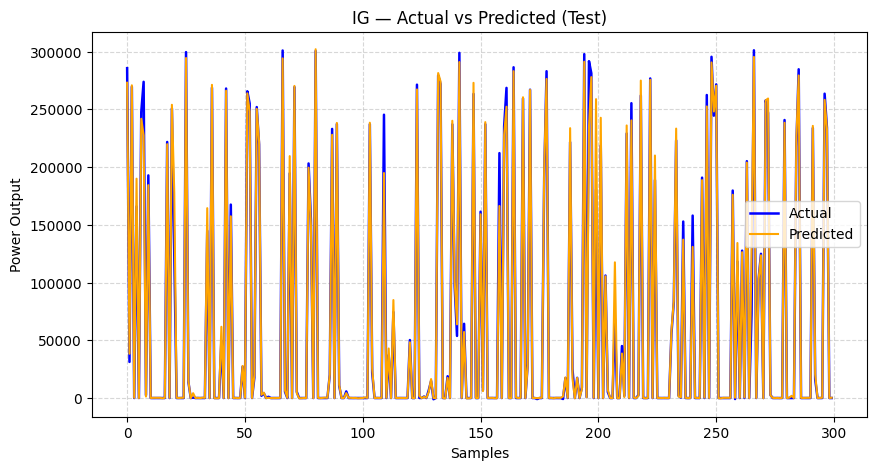

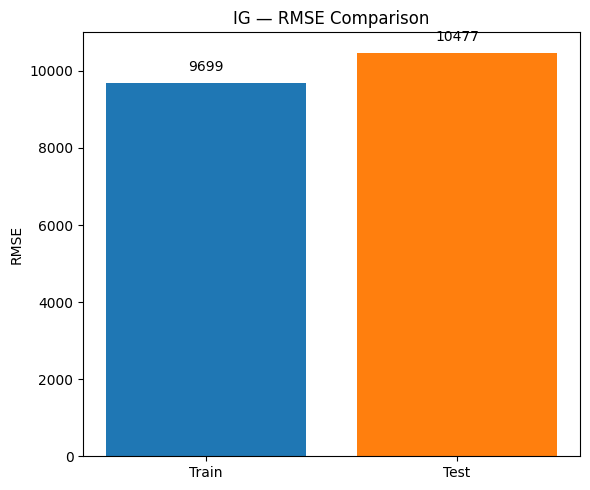

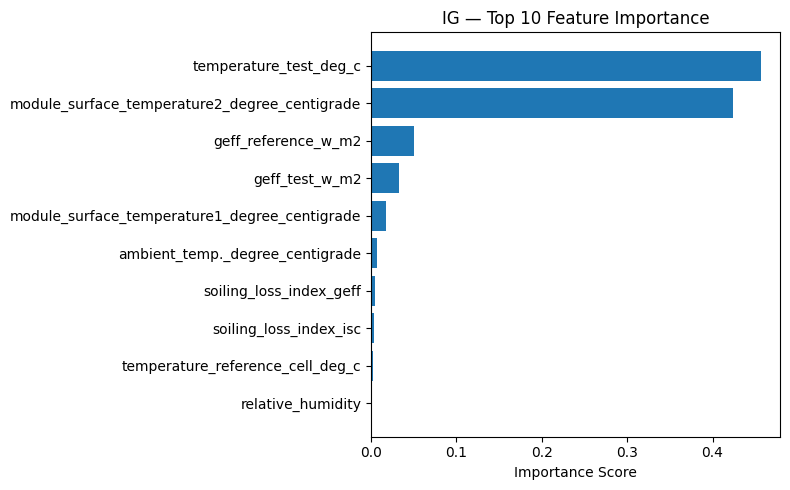


🚀 Training PCC model...
Fitting 4 folds for each of 15 candidates, totalling 60 fits

📊 PCC Results:
   R² (Train): 0.9904 | R² (Test): 0.9889
   MSE (Train): 114,105,150.67 | MSE (Test): 131,908,718.31
   RMSE (Train): 10,682.00 | RMSE (Test): 11,485.15
   Status: ✅ Good Fit (ΔRMSE=7.52%)
💾 Saved PCC model → /Users/shthaz/Desktop/Solar_Panels2/Data/xgb_pcc_winter.joblib


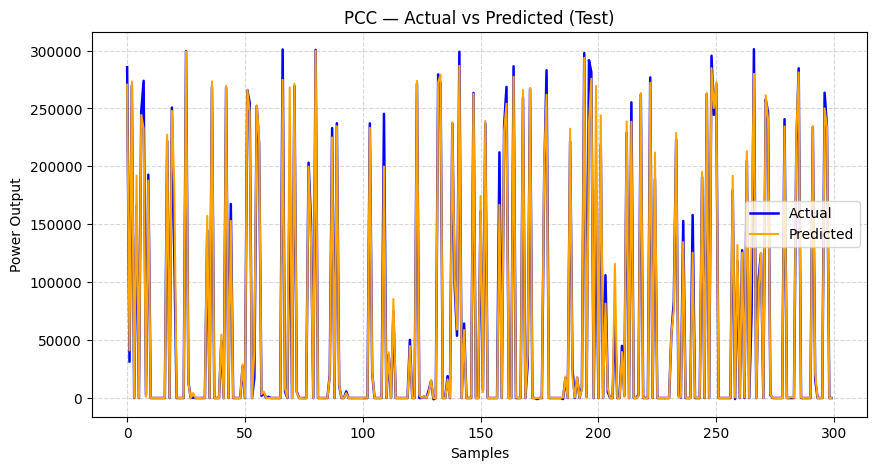

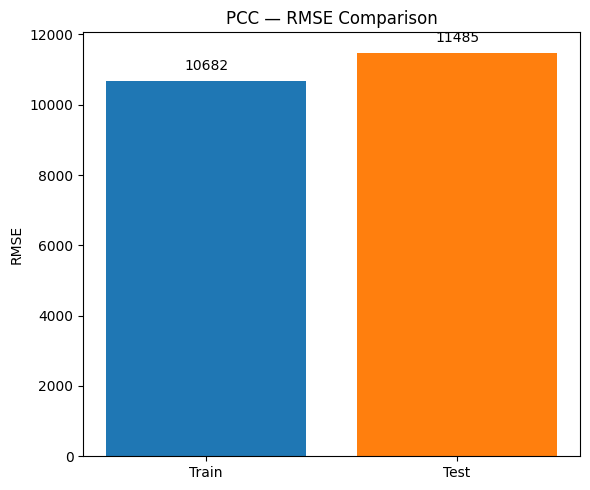

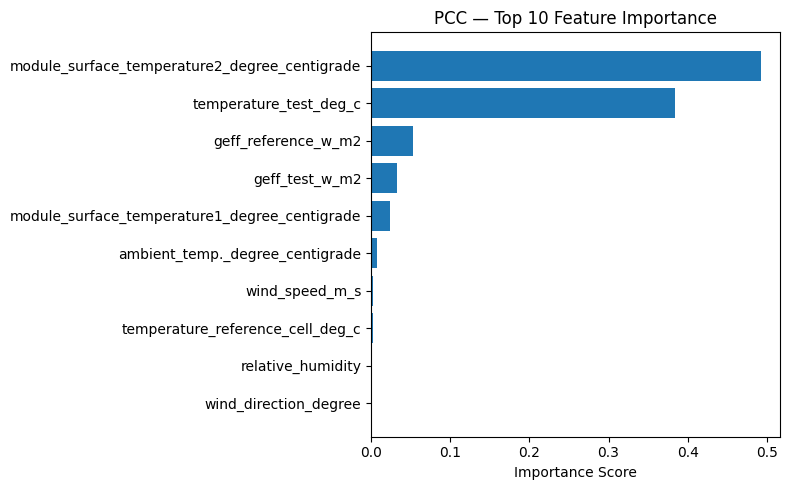


🏁 WINTER MODEL COMPARISON
IG → R²(Test): 0.9908 | RMSE(Test): 10477.4 | Status: ✅ Good Fit
PCC → R²(Test): 0.9889 | RMSE(Test): 11485.2 | Status: ✅ Good Fit

✅ IG performed better for WINTER based on test accuracy.
💾 Best model saved as → xgb_winter_best.joblib


In [24]:
# ============================================================
# ❄️ XGBoost Training & Visualization for WINTER (Anti-Overfit)
# ============================================================

import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# -----------------------------
# 📂 Paths
# -----------------------------
DATA_DIR = os.path.expanduser("~/Desktop/Solar_Panels2/Data")
train_path = os.path.join(DATA_DIR, "all_data_winter_train_clean.h5")
test_path  = os.path.join(DATA_DIR, "all_data_winter_test_clean.h5")
features_path = os.path.join(DATA_DIR, "selected_features_winter_ig_pcc.joblib")

# -----------------------------
# 📊 Load data
# -----------------------------
print("📦 Loading training and testing data...")
train_df = pd.read_hdf(train_path, 'df')
test_df  = pd.read_hdf(test_path, 'df')
features = joblib.load(features_path)

print(f"✅ Train: {train_df.shape}, Test: {test_df.shape}")

target_col = train_df.columns[-1]
X_train, y_train = train_df.iloc[:, :-1], train_df.iloc[:, -1]
X_test,  y_test  = test_df.iloc[:, :-1],  test_df.iloc[:, -1]

# -----------------------------
# ⚙️ Anti-Overfitting Parameter Grid
# -----------------------------
param_grid = {
    "n_estimators": [200, 250, 300],
    "learning_rate": [0.02, 0.03, 0.05],
    "max_depth": [4, 5, 6],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "reg_alpha": [0.3, 0.5, 0.7],
    "reg_lambda": [1.0, 1.5, 2.0],
    "min_child_weight": [3, 5, 7]
}

# -----------------------------
# 🧠 Training function
# -----------------------------
def train_and_evaluate(X_train, y_train, X_test, y_test, feature_set_name, feature_list):
    print(f"\n🚀 Training {feature_set_name} model...")

    model = XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    )

    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=15,         
        cv=4,             
        verbose=1,
        n_jobs=-1,
        scoring='r2',
        random_state=42
    )

    search.fit(X_train[feature_list], y_train)
    best_model = search.best_estimator_

    # 📊 Predictions
    y_pred_train = best_model.predict(X_train[feature_list])
    y_pred_test  = best_model.predict(X_test[feature_list])

    # 📈 Metrics
    r2_train = r2_score(y_train, y_pred_train)
    r2_test  = r2_score(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test  = mean_squared_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test  = np.sqrt(mse_test)
    delta_rmse = ((rmse_test - rmse_train) / rmse_train) * 100

    # 🔍 Fit status
    if delta_rmse > 30:
        status = "🚨 Overfitting!"
    elif delta_rmse < -10:
        status = "⚠️ Underfitting!"
    else:
        status = "✅ Good Fit"

    print(f"\n📊 {feature_set_name} Results:")
    print(f"   R² (Train): {r2_train:.4f} | R² (Test): {r2_test:.4f}")
    print(f"   MSE (Train): {mse_train:,.2f} | MSE (Test): {mse_test:,.2f}")
    print(f"   RMSE (Train): {rmse_train:,.2f} | RMSE (Test): {rmse_test:,.2f}")
    print(f"   Status: {status} (ΔRMSE={delta_rmse:.2f}%)")

    # 💾 Save model
    model_path = os.path.join(DATA_DIR, f"xgb_{feature_set_name.lower()}_winter.joblib")
    joblib.dump(best_model, model_path)
    print(f"💾 Saved {feature_set_name} model → {model_path}")

    # 🎨 Plots
    # 1️⃣ Actual vs Predicted (Test)
    plt.figure(figsize=(10,5))
    plt.plot(y_test.values[:300], label="Actual", color="blue", linewidth=1.8)
    plt.plot(y_pred_test[:300], label="Predicted", color="orange", linewidth=1.5)
    plt.title(f"{feature_set_name} — Actual vs Predicted (Test)")
    plt.xlabel("Samples")
    plt.ylabel("Power Output")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

    # 2️⃣ RMSE comparison (Bar chart)
    plt.figure(figsize=(6,5))
    bars = plt.bar(["Train", "Test"], [rmse_train, rmse_test], color=["#1f77b4", "#ff7f0e"])
    plt.title(f"{feature_set_name} — RMSE Comparison")
    plt.ylabel("RMSE")
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 300, f"{height:.0f}", ha='center', fontsize=10)
    plt.tight_layout()
    plt.show()

    # 3️⃣ Feature Importance
    plt.figure(figsize=(8,5))
    importance = best_model.feature_importances_
    sorted_idx = np.argsort(importance)[::-1]
    plt.barh(np.array(feature_list)[sorted_idx][:10][::-1],
             importance[sorted_idx][:10][::-1], color="#1f77b4")
    plt.title(f"{feature_set_name} — Top 10 Feature Importance")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()

    return {
        "name": feature_set_name,
        "model": best_model,
        "r2_train": r2_train,
        "r2_test": r2_test,
        "mse_train": mse_train,
        "mse_test": mse_test,
        "rmse_train": rmse_train,
        "rmse_test": rmse_test,
        "status": status
    }

# -----------------------------
# 🧪 Train both IG & PCC
# -----------------------------
ig_result = train_and_evaluate(X_train, y_train, X_test, y_test, "IG", features["ig"])
pcc_result = train_and_evaluate(X_train, y_train, X_test, y_test, "PCC", features["pcc"])

# -----------------------------
# 🏁 Compare and Save Best Model
# -----------------------------
print("\n===============================")
print("🏁 WINTER MODEL COMPARISON")
print("===============================")
print(f"IG → R²(Test): {ig_result['r2_test']:.4f} | RMSE(Test): {ig_result['rmse_test']:.1f} | Status: {ig_result['status']}")
print(f"PCC → R²(Test): {pcc_result['r2_test']:.4f} | RMSE(Test): {pcc_result['rmse_test']:.1f} | Status: {pcc_result['status']}")

if ig_result['r2_test'] > pcc_result['r2_test']:
    print("\n✅ IG performed better for WINTER based on test accuracy.")
    joblib.dump(ig_result["model"], os.path.join(DATA_DIR, "xgb_winter_best.joblib"))
else:
    print("\n✅ PCC performed better for WINTER based on test accuracy.")
    joblib.dump(pcc_result["model"], os.path.join(DATA_DIR, "xgb_winter_best.joblib"))

print("💾 Best model saved as → xgb_winter_best.joblib")


📦 Loading training and testing data...
✅ Train: (104334, 20), Test: (26084, 20)

🚀 Training IG model...
Fitting 4 folds for each of 15 candidates, totalling 60 fits

📊 IG Results:
   R² (Train): 0.9955 | R² (Test): 0.9952
   MSE (Train): 79,272,878.66 | MSE (Test): 84,871,494.32
   RMSE (Train): 8,903.53 | RMSE (Test): 9,212.57
   Status: ✅ Good Fit (ΔRMSE=3.47%)
💾 Saved IG model → /Users/shthaz/Desktop/Solar_Panels2/Data/xgb_ig_spring.joblib


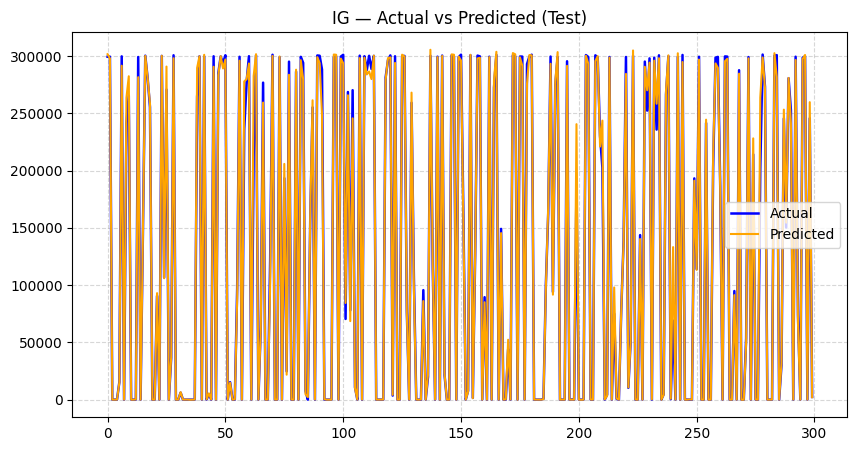

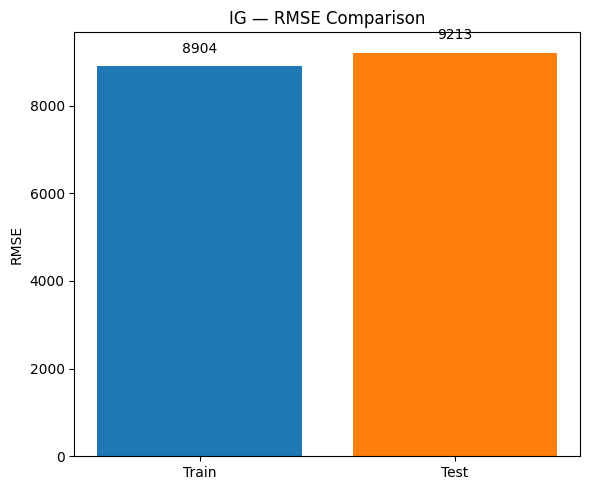

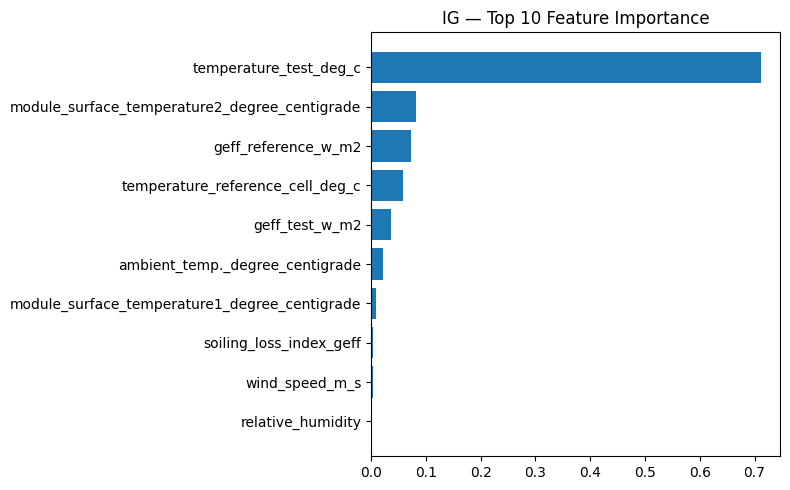


🚀 Training PCC model...
Fitting 4 folds for each of 15 candidates, totalling 60 fits

📊 PCC Results:
   R² (Train): 0.9949 | R² (Test): 0.9946
   MSE (Train): 89,946,717.17 | MSE (Test): 96,230,532.93
   RMSE (Train): 9,484.02 | RMSE (Test): 9,809.72
   Status: ✅ Good Fit (ΔRMSE=3.43%)
💾 Saved PCC model → /Users/shthaz/Desktop/Solar_Panels2/Data/xgb_pcc_spring.joblib


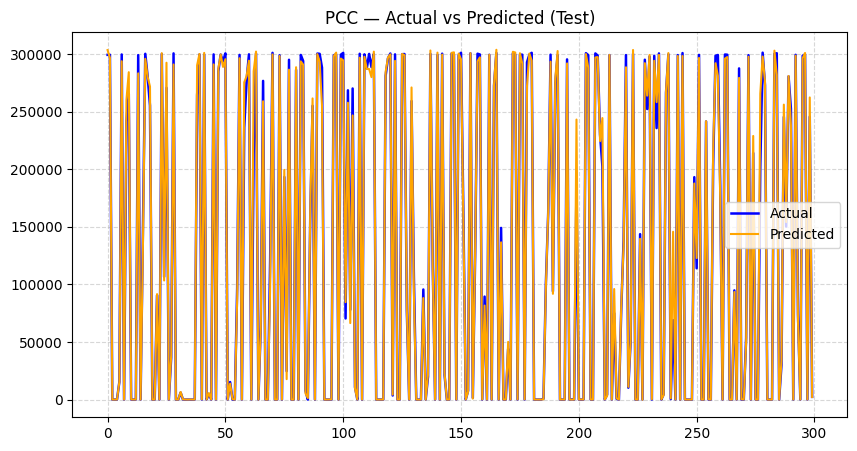

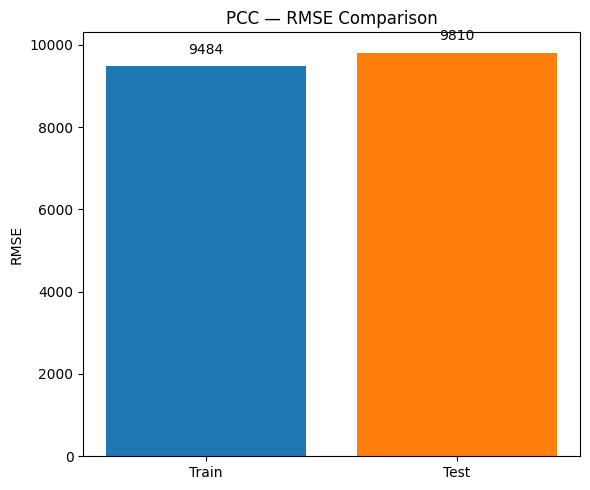

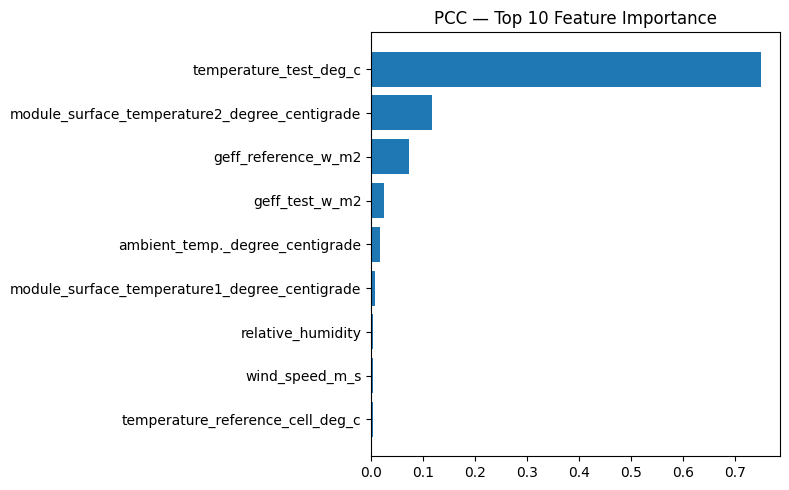


🏁 SPRING MODEL COMPARISON
IG → R²(Test): 0.9952 | RMSE(Test): 9212.6 | ✅ Good Fit
PCC → R²(Test): 0.9946 | RMSE(Test): 9809.7 | ✅ Good Fit
✅ IG performed better for SPRING.
💾 Best model saved as → xgb_spring_best.joblib


In [25]:
# ============================================================
# 🌸 XGBoost Training & Visualization for SPRING (Anti-Overfit)
# ============================================================

import pandas as pd, numpy as np, joblib, os, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

DATA_DIR = os.path.expanduser("~/Desktop/Solar_Panels2/Data")
train_path = os.path.join(DATA_DIR, "all_data_spring_train_clean.h5")
test_path  = os.path.join(DATA_DIR, "all_data_spring_test_clean.h5")
features_path = os.path.join(DATA_DIR, "selected_features_spring_ig_pcc.joblib")

print("📦 Loading training and testing data...")
train_df = pd.read_hdf(train_path, 'df')
test_df  = pd.read_hdf(test_path, 'df')
features = joblib.load(features_path)
print(f"✅ Train: {train_df.shape}, Test: {test_df.shape}")

target_col = train_df.columns[-1]
X_train, y_train = train_df.iloc[:, :-1], train_df.iloc[:, -1]
X_test,  y_test  = test_df.iloc[:, :-1],  test_df.iloc[:, -1]

param_grid = {
    "n_estimators": [200, 250, 300],
    "learning_rate": [0.02, 0.03, 0.05],
    "max_depth": [4, 5, 6],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "reg_alpha": [0.3, 0.5, 0.7],
    "reg_lambda": [1.0, 1.5, 2.0],
    "min_child_weight": [3, 5, 7]
}

def train_and_evaluate(X_train, y_train, X_test, y_test, feature_set_name, feature_list):
    print(f"\n🚀 Training {feature_set_name} model...")
    model = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
    search = RandomizedSearchCV(model, param_grid, n_iter=15, cv=4, scoring='r2', n_jobs=-1, verbose=1, random_state=42)
    search.fit(X_train[feature_list], y_train)
    best_model = search.best_estimator_
    y_pred_train = best_model.predict(X_train[feature_list])
    y_pred_test  = best_model.predict(X_test[feature_list])
    r2_train, r2_test = r2_score(y_train, y_pred_train), r2_score(y_test, y_pred_test)
    mse_train, mse_test = mean_squared_error(y_train, y_pred_train), mean_squared_error(y_test, y_pred_test)
    rmse_train, rmse_test = np.sqrt(mse_train), np.sqrt(mse_test)
    delta_rmse = ((rmse_test - rmse_train) / rmse_train) * 100
    status = "🚨 Overfitting!" if delta_rmse > 30 else "⚠️ Underfitting!" if delta_rmse < -10 else "✅ Good Fit"
    print(f"\n📊 {feature_set_name} Results:")
    print(f"   R² (Train): {r2_train:.4f} | R² (Test): {r2_test:.4f}")
    print(f"   MSE (Train): {mse_train:,.2f} | MSE (Test): {mse_test:,.2f}")
    print(f"   RMSE (Train): {rmse_train:,.2f} | RMSE (Test): {rmse_test:,.2f}")
    print(f"   Status: {status} (ΔRMSE={delta_rmse:.2f}%)")

    model_path = os.path.join(DATA_DIR, f"xgb_{feature_set_name.lower()}_spring.joblib")
    joblib.dump(best_model, model_path)
    print(f"💾 Saved {feature_set_name} model → {model_path}")

    plt.figure(figsize=(10,5))
    plt.plot(y_test.values[:300], label="Actual", color="blue", linewidth=1.8)
    plt.plot(y_pred_test[:300], label="Predicted", color="orange", linewidth=1.5)
    plt.title(f"{feature_set_name} — Actual vs Predicted (Test)")
    plt.legend(); plt.grid(True, linestyle="--", alpha=0.5); plt.show()

    plt.figure(figsize=(6,5))
    bars = plt.bar(["Train","Test"], [rmse_train,rmse_test], color=["#1f77b4","#ff7f0e"])
    for b in bars: plt.text(b.get_x()+b.get_width()/2,b.get_height()+300,f"{b.get_height():.0f}",ha='center')
    plt.title(f"{feature_set_name} — RMSE Comparison"); plt.ylabel("RMSE"); plt.tight_layout(); plt.show()

    plt.figure(figsize=(8,5))
    imp = best_model.feature_importances_; idx = np.argsort(imp)[::-1]
    plt.barh(np.array(feature_list)[idx][:10][::-1], imp[idx][:10][::-1], color="#1f77b4")
    plt.title(f"{feature_set_name} — Top 10 Feature Importance"); plt.tight_layout(); plt.show()

    return {"name":feature_set_name,"model":best_model,"r2_test":r2_test,"rmse_test":rmse_test,"status":status}

ig=train_and_evaluate(X_train,y_train,X_test,y_test,"IG",features["ig"])
pcc=train_and_evaluate(X_train,y_train,X_test,y_test,"PCC",features["pcc"])
print("\n🏁 SPRING MODEL COMPARISON")
print(f"IG → R²(Test): {ig['r2_test']:.4f} | RMSE(Test): {ig['rmse_test']:.1f} | {ig['status']}")
print(f"PCC → R²(Test): {pcc['r2_test']:.4f} | RMSE(Test): {pcc['rmse_test']:.1f} | {pcc['status']}")
if ig['r2_test']>pcc['r2_test']:
    print("✅ IG performed better for SPRING."); joblib.dump(ig["model"],os.path.join(DATA_DIR,"xgb_spring_best.joblib"))
else:
    print("✅ PCC performed better for SPRING."); joblib.dump(pcc["model"],os.path.join(DATA_DIR,"xgb_spring_best.joblib"))
print("💾 Best model saved as → xgb_spring_best.joblib")


📦 Loading training and testing data...
✅ Train: (105962, 20), Test: (26491, 20)

🚀 Training IG model...
Fitting 4 folds for each of 15 candidates, totalling 60 fits

📊 IG Results:
   R² (Train): 0.9976 | R² (Test): 0.9971
   MSE (Train): 46,914,694.07 | MSE (Test): 56,450,330.32
   RMSE (Train): 6,849.43 | RMSE (Test): 7,513.34
   Status: ✅ Good Fit (ΔRMSE=9.69%)
💾 Saved IG model → /Users/shthaz/Desktop/Solar_Panels2/Data/xgb_ig_summer.joblib


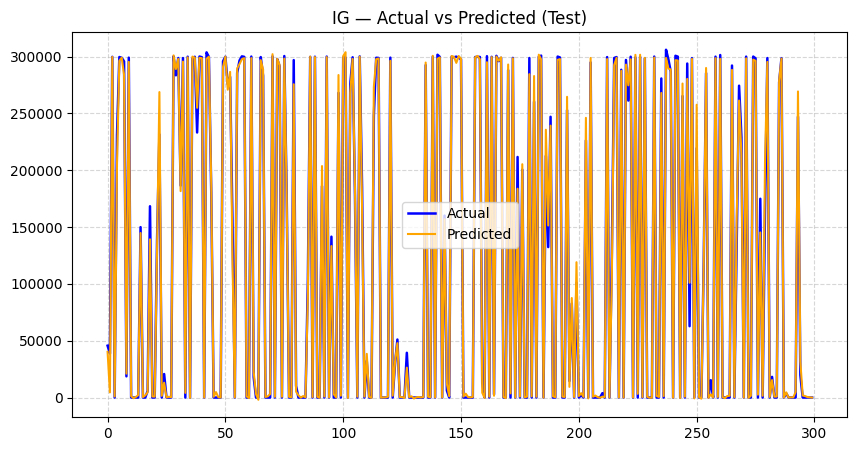

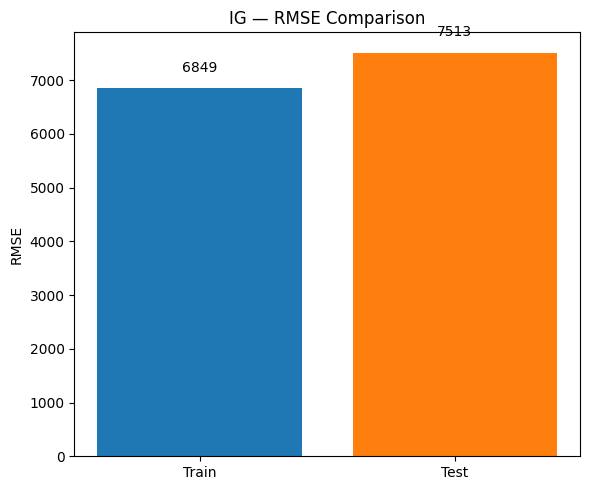

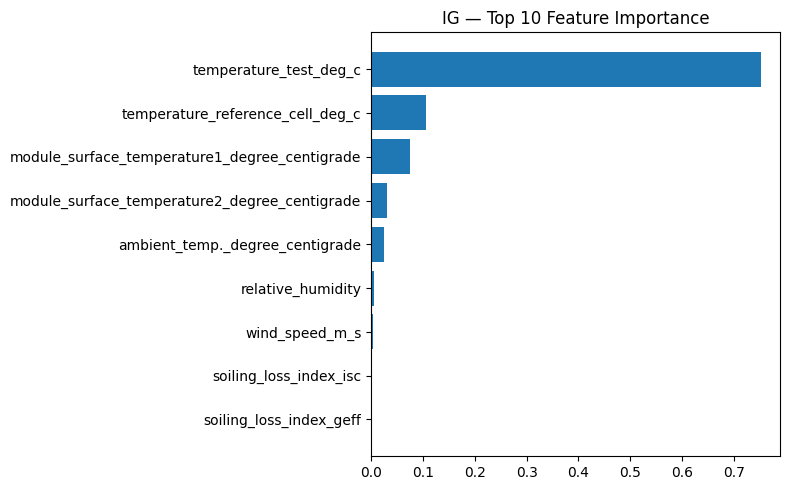


🚀 Training PCC model...
Fitting 4 folds for each of 15 candidates, totalling 60 fits

📊 PCC Results:
   R² (Train): 0.9970 | R² (Test): 0.9962
   MSE (Train): 58,717,161.40 | MSE (Test): 73,512,897.18
   RMSE (Train): 7,662.71 | RMSE (Test): 8,573.97
   Status: ✅ Good Fit (ΔRMSE=11.89%)
💾 Saved PCC model → /Users/shthaz/Desktop/Solar_Panels2/Data/xgb_pcc_summer.joblib


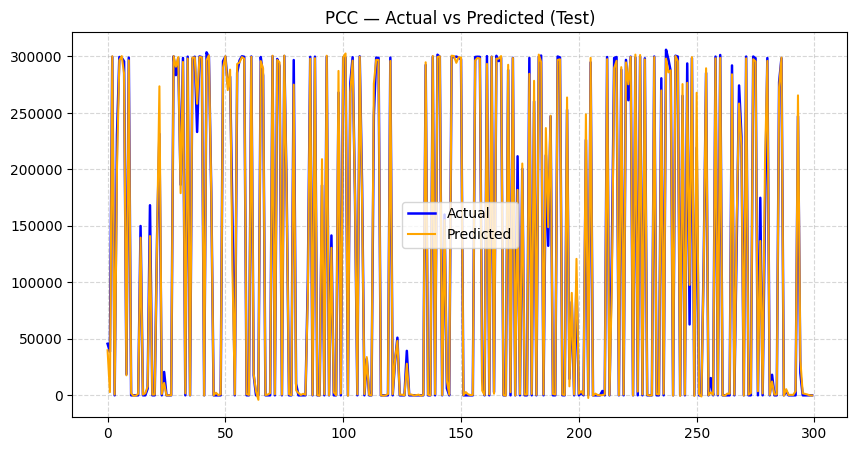

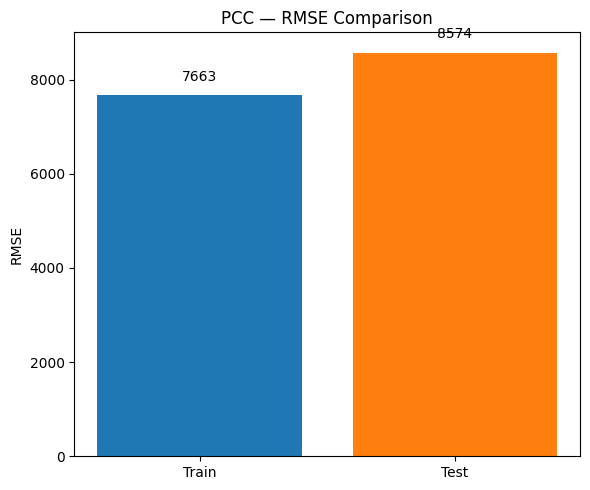

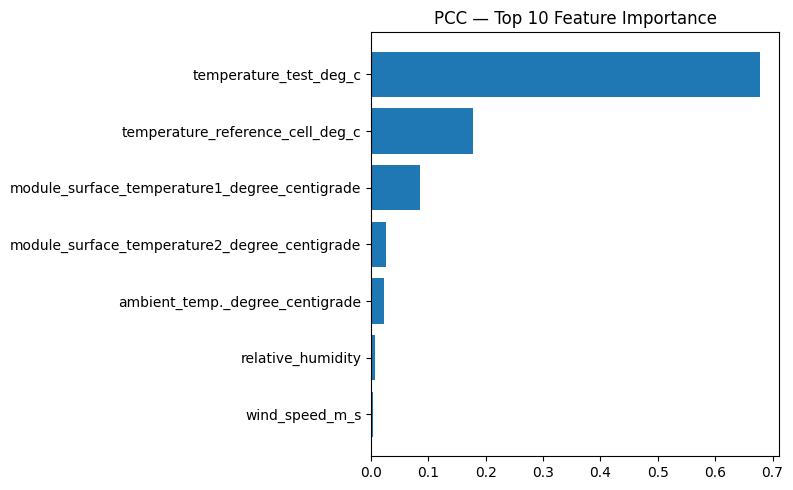


🏁 SUMMER MODEL COMPARISON
IG → R²(Test): 0.9971 | RMSE(Test): 7513.3 | ✅ Good Fit
PCC → R²(Test): 0.9962 | RMSE(Test): 8574.0 | ✅ Good Fit
✅ IG performed better for SUMMER.
💾 Best model saved as → xgb_summer_best.joblib


In [26]:
# ============================================================
# ☀️ XGBoost Training & Visualization for SUMMER (Anti-Overfit)
# ============================================================

import pandas as pd, numpy as np, joblib, os, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# -----------------------------
# 📂 Paths
# -----------------------------
DATA_DIR = os.path.expanduser("~/Desktop/Solar_Panels2/Data")
train_path = os.path.join(DATA_DIR, "all_data_summer_train_clean.h5")
test_path  = os.path.join(DATA_DIR, "all_data_summer_test_clean.h5")
features_path = os.path.join(DATA_DIR, "selected_features_summer_ig_pcc.joblib")

# -----------------------------
# 📊 Load data
# -----------------------------
print("📦 Loading training and testing data...")
train_df = pd.read_hdf(train_path, 'df')
test_df  = pd.read_hdf(test_path, 'df')
features = joblib.load(features_path)

print(f"✅ Train: {train_df.shape}, Test: {test_df.shape}")

target_col = train_df.columns[-1]
X_train, y_train = train_df.iloc[:, :-1], train_df.iloc[:, -1]
X_test,  y_test  = test_df.iloc[:, :-1],  test_df.iloc[:, -1]

# -----------------------------
# ⚙️ Parameter Grid
# -----------------------------
param_grid = {
    "n_estimators": [200, 250, 300],
    "learning_rate": [0.02, 0.03, 0.05],
    "max_depth": [4, 5, 6],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "reg_alpha": [0.3, 0.5, 0.7],
    "reg_lambda": [1.0, 1.5, 2.0],
    "min_child_weight": [3, 5, 7]
}

# -----------------------------
# 🧠 Training Function
# -----------------------------
def train_and_evaluate(X_train, y_train, X_test, y_test, feature_set_name, feature_list):
    print(f"\n🚀 Training {feature_set_name} model...")

    model = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

    search = RandomizedSearchCV(model, param_grid, n_iter=15, cv=4, scoring='r2', n_jobs=-1, verbose=1, random_state=42)
    search.fit(X_train[feature_list], y_train)
    best_model = search.best_estimator_

    # Predictions
    y_pred_train = best_model.predict(X_train[feature_list])
    y_pred_test  = best_model.predict(X_test[feature_list])

    # Metrics
    r2_train, r2_test = r2_score(y_train, y_pred_train), r2_score(y_test, y_pred_test)
    mse_train, mse_test = mean_squared_error(y_train, y_pred_train), mean_squared_error(y_test, y_pred_test)
    rmse_train, rmse_test = np.sqrt(mse_train), np.sqrt(mse_test)
    delta_rmse = ((rmse_test - rmse_train) / rmse_train) * 100

    if delta_rmse > 30:
        status = "🚨 Overfitting!"
    elif delta_rmse < -10:
        status = "⚠️ Underfitting!"
    else:
        status = "✅ Good Fit"

    print(f"\n📊 {feature_set_name} Results:")
    print(f"   R² (Train): {r2_train:.4f} | R² (Test): {r2_test:.4f}")
    print(f"   MSE (Train): {mse_train:,.2f} | MSE (Test): {mse_test:,.2f}")
    print(f"   RMSE (Train): {rmse_train:,.2f} | RMSE (Test): {rmse_test:,.2f}")
    print(f"   Status: {status} (ΔRMSE={delta_rmse:.2f}%)")

    model_path = os.path.join(DATA_DIR, f"xgb_{feature_set_name.lower()}_summer.joblib")
    joblib.dump(best_model, model_path)
    print(f"💾 Saved {feature_set_name} model → {model_path}")

    # 1️⃣ Actual vs Predicted
    plt.figure(figsize=(10,5))
    plt.plot(y_test.values[:300], label="Actual", color="blue", linewidth=1.8)
    plt.plot(y_pred_test[:300], label="Predicted", color="orange", linewidth=1.5)
    plt.title(f"{feature_set_name} — Actual vs Predicted (Test)")
    plt.legend(); plt.grid(True, linestyle="--", alpha=0.5); plt.show()

    # 2️⃣ RMSE Comparison
    plt.figure(figsize=(6,5))
    bars = plt.bar(["Train","Test"], [rmse_train, rmse_test], color=["#1f77b4","#ff7f0e"])
    for b in bars: plt.text(b.get_x()+b.get_width()/2,b.get_height()+300,f"{b.get_height():.0f}",ha='center')
    plt.title(f"{feature_set_name} — RMSE Comparison"); plt.ylabel("RMSE"); plt.tight_layout(); plt.show()

    # 3️⃣ Feature Importance
    plt.figure(figsize=(8,5))
    imp = best_model.feature_importances_; idx = np.argsort(imp)[::-1]
    plt.barh(np.array(feature_list)[idx][:10][::-1], imp[idx][:10][::-1], color="#1f77b4")
    plt.title(f"{feature_set_name} — Top 10 Feature Importance"); plt.tight_layout(); plt.show()

    return {"name":feature_set_name,"model":best_model,"r2_test":r2_test,"rmse_test":rmse_test,"status":status}

# -----------------------------
# 🧪 Train both IG & PCC
# -----------------------------
ig=train_and_evaluate(X_train,y_train,X_test,y_test,"IG",features["ig"])
pcc=train_and_evaluate(X_train,y_train,X_test,y_test,"PCC",features["pcc"])

# -----------------------------
# 🏁 Compare and Save Best Model
# -----------------------------
print("\n===============================")
print("🏁 SUMMER MODEL COMPARISON")
print("===============================")
print(f"IG → R²(Test): {ig['r2_test']:.4f} | RMSE(Test): {ig['rmse_test']:.1f} | {ig['status']}")
print(f"PCC → R²(Test): {pcc['r2_test']:.4f} | RMSE(Test): {pcc['rmse_test']:.1f} | {pcc['status']}")

if ig['r2_test']>pcc['r2_test']:
    print("✅ IG performed better for SUMMER.")
    joblib.dump(ig["model"],os.path.join(DATA_DIR,"xgb_summer_best.joblib"))
else:
    print("✅ PCC performed better for SUMMER.")
    joblib.dump(pcc["model"],os.path.join(DATA_DIR,"xgb_summer_best.joblib"))

print("💾 Best model saved as → xgb_summer_best.joblib")


📦 Loading training and testing data...
✅ Train: (104780, 20), Test: (26196, 20)

🚀 Training IG model...
Fitting 4 folds for each of 15 candidates, totalling 60 fits

📊 IG Results:
   R² (Train): 0.9939 | R² (Test): 0.9931
   MSE (Train): 86,947,778.91 | MSE (Test): 98,234,052.58
   RMSE (Train): 9,324.58 | RMSE (Test): 9,911.31
   Status: ✅ Good Fit (ΔRMSE=6.29%)
💾 Saved IG model → /Users/shthaz/Desktop/Solar_Panels2/Data/xgb_ig_fall.joblib


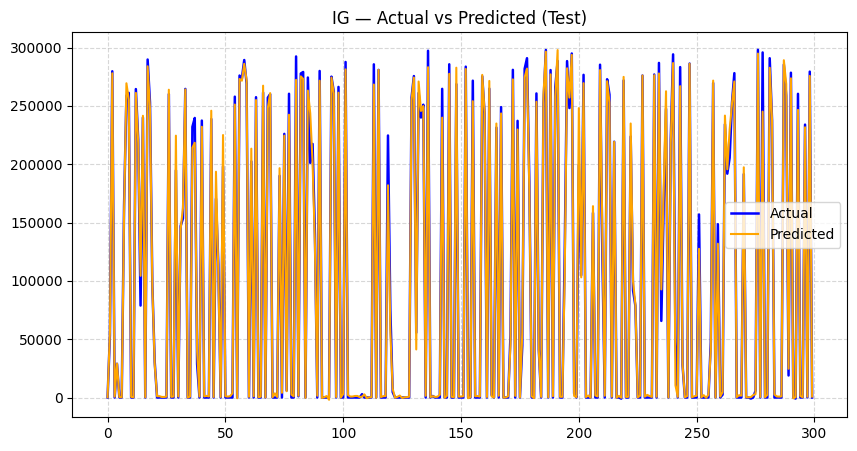

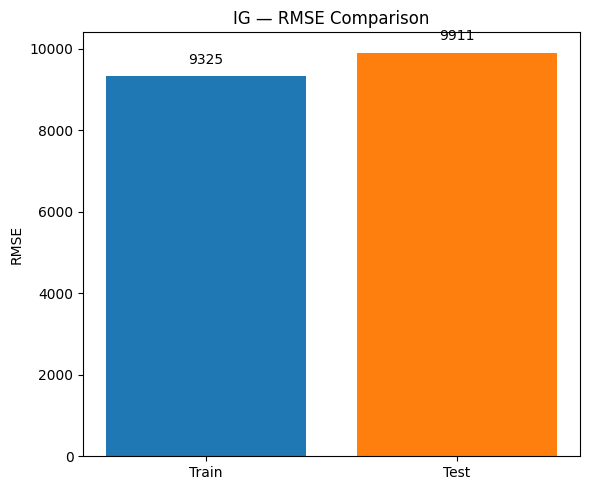

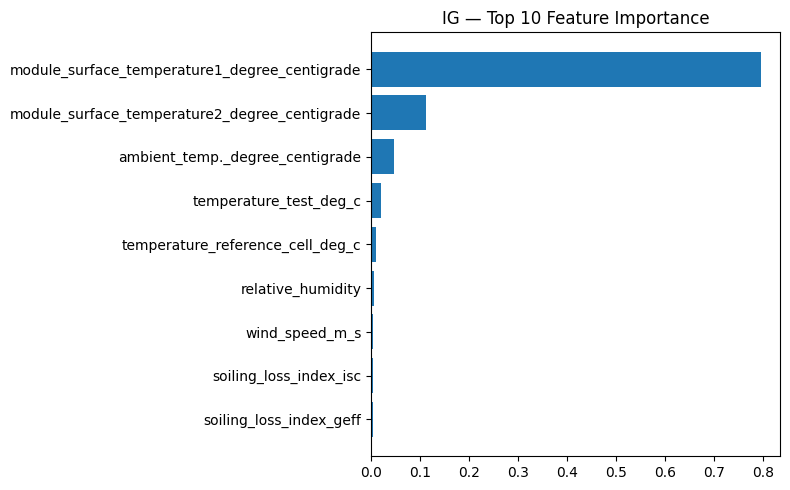


🚀 Training PCC model...
Fitting 4 folds for each of 15 candidates, totalling 60 fits

📊 PCC Results:
   R² (Train): 0.9927 | R² (Test): 0.9916
   MSE (Train): 104,313,928.37 | MSE (Test): 120,132,489.16
   RMSE (Train): 10,213.42 | RMSE (Test): 10,960.50
   Status: ✅ Good Fit (ΔRMSE=7.31%)
💾 Saved PCC model → /Users/shthaz/Desktop/Solar_Panels2/Data/xgb_pcc_fall.joblib


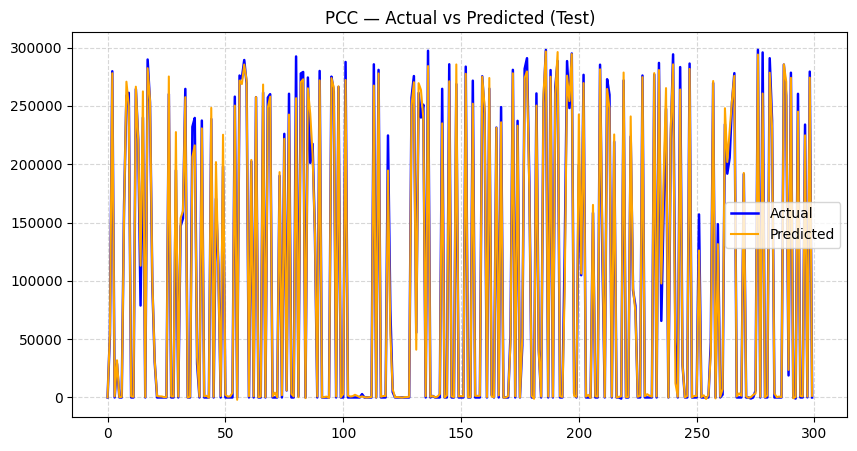

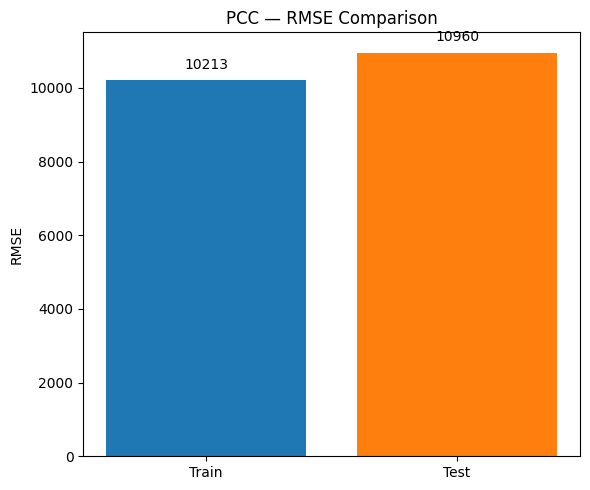

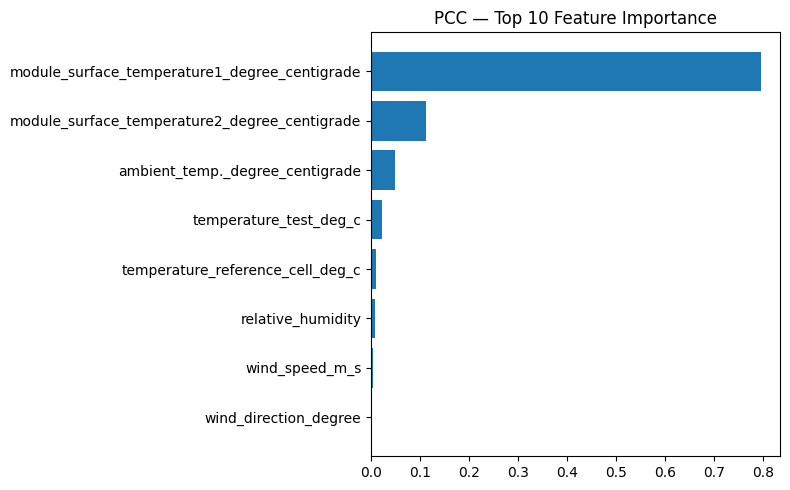


🏁 FALL MODEL COMPARISON
IG → R²(Test): 0.9931 | RMSE(Test): 9911.3 | ✅ Good Fit
PCC → R²(Test): 0.9916 | RMSE(Test): 10960.5 | ✅ Good Fit
✅ IG performed better for FALL.
💾 Best model saved as → xgb_fall_best.joblib


In [27]:
# ============================================================
# 🍂 XGBoost Training & Visualization for FALL (Anti-Overfit)
# ============================================================

import pandas as pd, numpy as np, joblib, os, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# -----------------------------
# 📂 Paths
# -----------------------------
DATA_DIR = os.path.expanduser("~/Desktop/Solar_Panels2/Data")
train_path = os.path.join(DATA_DIR, "all_data_fall_train_clean.h5")
test_path  = os.path.join(DATA_DIR, "all_data_fall_test_clean.h5")
features_path = os.path.join(DATA_DIR, "selected_features_fall_ig_pcc.joblib")

# -----------------------------
# 📊 Load data
# -----------------------------
print("📦 Loading training and testing data...")
train_df = pd.read_hdf(train_path, 'df')
test_df  = pd.read_hdf(test_path, 'df')
features = joblib.load(features_path)

print(f"✅ Train: {train_df.shape}, Test: {test_df.shape}")

target_col = train_df.columns[-1]
X_train, y_train = train_df.iloc[:, :-1], train_df.iloc[:, -1]
X_test,  y_test  = test_df.iloc[:, :-1],  test_df.iloc[:, -1]

# -----------------------------
# ⚙️ Parameter Grid
# -----------------------------
param_grid = {
    "n_estimators": [200, 250, 300],
    "learning_rate": [0.02, 0.03, 0.05],
    "max_depth": [4, 5, 6],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "reg_alpha": [0.3, 0.5, 0.7],
    "reg_lambda": [1.0, 1.5, 2.0],
    "min_child_weight": [3, 5, 7]
}

# -----------------------------
# 🧠 Training Function
# -----------------------------
def train_and_evaluate(X_train, y_train, X_test, y_test, feature_set_name, feature_list):
    print(f"\n🚀 Training {feature_set_name} model...")

    model = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

    search = RandomizedSearchCV(model, param_grid, n_iter=15, cv=4, scoring='r2', n_jobs=-1, verbose=1, random_state=42)
    search.fit(X_train[feature_list], y_train)
    best_model = search.best_estimator_

    # Predictions
    y_pred_train = best_model.predict(X_train[feature_list])
    y_pred_test  = best_model.predict(X_test[feature_list])

    # Metrics
    r2_train, r2_test = r2_score(y_train, y_pred_train), r2_score(y_test, y_pred_test)
    mse_train, mse_test = mean_squared_error(y_train, y_pred_train), mean_squared_error(y_test, y_pred_test)
    rmse_train, rmse_test = np.sqrt(mse_train), np.sqrt(mse_test)
    delta_rmse = ((rmse_test - rmse_train) / rmse_train) * 100

    if delta_rmse > 30:
        status = "🚨 Overfitting!"
    elif delta_rmse < -10:
        status = "⚠️ Underfitting!"
    else:
        status = "✅ Good Fit"

    print(f"\n📊 {feature_set_name} Results:")
    print(f"   R² (Train): {r2_train:.4f} | R² (Test): {r2_test:.4f}")
    print(f"   MSE (Train): {mse_train:,.2f} | MSE (Test): {mse_test:,.2f}")
    print(f"   RMSE (Train): {rmse_train:,.2f} | RMSE (Test): {rmse_test:,.2f}")
    print(f"   Status: {status} (ΔRMSE={delta_rmse:.2f}%)")

    model_path = os.path.join(DATA_DIR, f"xgb_{feature_set_name.lower()}_fall.joblib")
    joblib.dump(best_model, model_path)
    print(f"💾 Saved {feature_set_name} model → {model_path}")

    # 1️⃣ Actual vs Predicted
    plt.figure(figsize=(10,5))
    plt.plot(y_test.values[:300], label="Actual", color="blue", linewidth=1.8)
    plt.plot(y_pred_test[:300], label="Predicted", color="orange", linewidth=1.5)
    plt.title(f"{feature_set_name} — Actual vs Predicted (Test)")
    plt.legend(); plt.grid(True, linestyle="--", alpha=0.5); plt.show()

    # 2️⃣ RMSE Comparison
    plt.figure(figsize=(6,5))
    bars = plt.bar(["Train","Test"], [rmse_train, rmse_test], color=["#1f77b4","#ff7f0e"])
    for b in bars: plt.text(b.get_x()+b.get_width()/2,b.get_height()+300,f"{b.get_height():.0f}",ha='center')
    plt.title(f"{feature_set_name} — RMSE Comparison"); plt.ylabel("RMSE"); plt.tight_layout(); plt.show()

    # 3️⃣ Feature Importance
    plt.figure(figsize=(8,5))
    imp = best_model.feature_importances_; idx = np.argsort(imp)[::-1]
    plt.barh(np.array(feature_list)[idx][:10][::-1], imp[idx][:10][::-1], color="#1f77b4")
    plt.title(f"{feature_set_name} — Top 10 Feature Importance"); plt.tight_layout(); plt.show()

    return {"name":feature_set_name,"model":best_model,"r2_test":r2_test,"rmse_test":rmse_test,"status":status}

# -----------------------------
# 🧪 Train both IG & PCC
# -----------------------------
ig=train_and_evaluate(X_train,y_train,X_test,y_test,"IG",features["ig"])
pcc=train_and_evaluate(X_train,y_train,X_test,y_test,"PCC",features["pcc"])

# -----------------------------
# 🏁 Compare and Save Best Model
# -----------------------------
print("\n===============================")
print("🏁 FALL MODEL COMPARISON")
print("===============================")
print(f"IG → R²(Test): {ig['r2_test']:.4f} | RMSE(Test): {ig['rmse_test']:.1f} | {ig['status']}")
print(f"PCC → R²(Test): {pcc['r2_test']:.4f} | RMSE(Test): {pcc['rmse_test']:.1f} | {pcc['status']}")

if ig['r2_test']>pcc['r2_test']:
    print("✅ IG performed better for FALL.")
    joblib.dump(ig["model"],os.path.join(DATA_DIR,"xgb_fall_best.joblib"))
else:
    print("✅ PCC performed better for FALL.")
    joblib.dump(pcc["model"],os.path.join(DATA_DIR,"xgb_fall_best.joblib"))

print("💾 Best model saved as → xgb_fall_best.joblib")


In [30]:
# ============================================================
# 🎲 Display 10 Random Actual vs Predicted Samples (Train & Test per Season)
# ============================================================

import random
import pandas as pd
import joblib
import os
import numpy as np

pd.set_option("display.precision", 4)

DATA_DIR = os.path.expanduser("~/Desktop/Solar_Panels2/Data")
seasons = ["winter", "spring", "summer", "fall"]

for season in seasons:
    print("\n" + "="*70)
    print(f"🌤️ Random 10 Actual vs Predicted Samples — {season.upper()}")
    print("="*70)

    best_model_path = os.path.join(DATA_DIR, f"xgb_{season}_best.joblib")
    train_path = os.path.join(DATA_DIR, f"all_data_{season}_train_clean.h5")
    test_path  = os.path.join(DATA_DIR, f"all_data_{season}_test_clean.h5")

    if not os.path.exists(best_model_path):
        print(f"⚠️ No trained model found for {season.upper()} — skipping.")
        continue

    # Load model and data
    model = joblib.load(best_model_path)
    train_df = pd.read_hdf(train_path, 'df')
    test_df  = pd.read_hdf(test_path, 'df')

    # Drop datetime columns
    datetime_cols = train_df.select_dtypes(include=['datetime64']).columns.tolist()
    if datetime_cols:
        print(f"🕒 Dropping datetime columns: {datetime_cols}")
        train_df = train_df.drop(columns=datetime_cols, errors='ignore')
        test_df  = test_df.drop(columns=datetime_cols, errors='ignore')

    X_train, y_train = train_df.iloc[:, :-1], train_df.iloc[:, -1]
    X_test,  y_test  = test_df.iloc[:, :-1],  test_df.iloc[:, -1]

    # ✅ Match feature names with model
    if hasattr(model, "feature_names_in_"):
        features_used = model.feature_names_in_
        X_train = X_train[features_used]
        X_test  = X_test[features_used]

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    # Select 10 random indices
    train_idx = random.sample(range(len(y_train)), 10)
    test_idx  = random.sample(range(len(y_test)), 10)

    # --- TRAIN SAMPLE ---
    print("\n--- TRAIN SAMPLE (10 random) ---")
    df_train_sample = pd.DataFrame({
        "Actual": y_train.iloc[train_idx].values,
        "Predicted": y_pred_train[train_idx],
        "Abs_Error": np.abs(y_train.iloc[train_idx].values - y_pred_train[train_idx])
    })
    print(df_train_sample.to_string(index=False))

    # --- TEST SAMPLE ---
    print("\n--- TEST SAMPLE (10 random) ---")
    df_test_sample = pd.DataFrame({
        "Actual": y_test.iloc[test_idx].values,
        "Predicted": y_pred_test[test_idx],
        "Abs_Error": np.abs(y_test.iloc[test_idx].values - y_pred_test[test_idx])
    })
    print(df_test_sample.to_string(index=False))

    # 📊 Print mean absolute error
    mean_error = np.mean(np.abs(y_test.values - y_pred_test))
    print(f"\n📈 Mean Absolute Error (Test): {mean_error:.2f}")

    print("\n" + "="*70)



🌤️ Random 10 Actual vs Predicted Samples — WINTER
🕒 Dropping datetime columns: ['time']

--- TRAIN SAMPLE (10 random) ---
   Actual   Predicted  Abs_Error
300058.84 291904.8750  8153.9650
     0.00   -159.7266   159.7266
     0.00    141.1379   141.1379
     0.00    -36.2067    36.2067
     0.00     76.4883    76.4883
246857.53 225677.2031 21180.3269
259239.00 246856.0469 12382.9531
     0.00     11.9152    11.9152
     0.00    -90.0907    90.0907
 97842.70  94903.1953  2939.5047

--- TEST SAMPLE (10 random) ---
   Actual   Predicted  Abs_Error
     0.00     22.9548    22.9548
228414.38 225647.3438  2767.0362
237590.44 234790.6875  2799.7525
     0.00     34.6738    34.6738
153868.34 163009.5312  9141.1913
     0.00    -29.0231    29.0231
     0.00    156.3644   156.3644
249887.48 253518.3594  3630.8794
286958.16 280312.7812  6645.3787
     0.00    161.0674   161.0674

📈 Mean Absolute Error (Test): 3856.16


🌤️ Random 10 Actual vs Predicted Samples — SPRING
🕒 Dropping datetime columns

In [3]:
# ============================================================
# 📊 System Capacity & RMSE Performance Evaluation (Auto Column Detect)
# ============================================================

import pandas as pd
import numpy as np
import os

# -----------------------------
# 📂 Paths
# -----------------------------
DATA_DIR = "/Users/shthaz/Desktop/v2/Data"
seasons = ["winter", "spring", "summer", "fall"]

# -----------------------------
# 🧮 Helper Function
# -----------------------------
def pct_of_cap(val, cap):
    """Calculate RMSE percentage relative to system capacity."""
    return (val / cap) * 100 if cap > 0 else np.nan

# -----------------------------
# 📊 Actual RMSE values from your models
# -----------------------------
rmse_values = {
    "winter": 10477.43,
    "spring": 9212.57,
    "summer": 7513.34,
    "fall":   9911.31
}

# -----------------------------
# 🧾 To store results
# -----------------------------
results = []

# -----------------------------
# 🔁 Evaluate Each Season
# -----------------------------
for season in seasons:
    print("\n" + "="*70)
    print(f"🌤️ {season.upper()} — Model Performance Evaluation")
    print("="*70)

    train_file = os.path.join(DATA_DIR, f"all_data_{season}_train_clean.h5")
    if not os.path.exists(train_file):
        print(f"⚠️ Missing training data for {season.upper()} — skipping.")
        continue

    # --- Load dataset ---
    df = pd.read_hdf(train_file, "df")

    # --- Detect target column automatically ---
    target_candidates = [c for c in df.columns if "power" in c.lower() and "active" in c.lower()]
    if not target_candidates:
        print("❌ Target column not found! Skipping.")
        continue

    target_col = target_candidates[0]
    subset = df[target_col].dropna()

    # --- Estimate System Capacity (robust approach) ---
    cap_p99 = subset.quantile(0.99)
    cap_p995 = subset.quantile(0.995)
    cap_top100 = subset.nlargest(100).median()
    cap_est = cap_p995  # Use P99.5 as stable capacity

    print(f"🔎 Estimated System Capacity (P99.5): {cap_est:,.0f} W")

    # --- Get RMSE for this season ---
    rmse_val = rmse_values.get(season, np.nan)
    if np.isnan(rmse_val):
        print(f"⚠️ No RMSE value for {season.upper()}")
        continue

    # --- Compute RMSE percentage relative to capacity ---
    rmse_percent = pct_of_cap(rmse_val, cap_est)

    # --- Assess performance level ---
    if rmse_percent < 5:
        level = "✅ Excellent Accuracy (High Performance)"
    elif rmse_percent < 10:
        level = "👌 Good Accuracy (Moderate Error)"
    else:
        level = "⚠️ Needs Improvement (High Error)"

    # --- Print Results ---
    print(f"📏 RMSE (Test): {rmse_val:,.2f}")
    print(f"📊 RMSE as % of System Capacity: {rmse_percent:.2f}%")
    print(f"💡 Performance Level → {level}")

    # --- Save result for ranking ---
    results.append({
        "Season": season.capitalize(),
        "Estimated Capacity (W)": round(cap_est, 2),
        "RMSE (Test)": round(rmse_val, 2),
        "RMSE % of Capacity": round(rmse_percent, 3),
        "Performance": level
    })

# -----------------------------
# 🏁 Overall Ranking
# -----------------------------
if results:
    df_results = pd.DataFrame(results)
    df_sorted = df_results.sort_values(by="RMSE % of Capacity", ascending=True).reset_index(drop=True)

    print("\n" + "="*70)
    print("🏆 OVERALL PERFORMANCE RANKING (Lowest RMSE% = Best Season)")
    print("="*70)
    print(df_sorted.to_string(index=False))

    best = df_sorted.iloc[0]
    worst = df_sorted.iloc[-1]

    print("\n🥇 Best Performing Season:")
    print(f"🌤️ {best['Season']} — RMSE={best['RMSE (Test)']:,.2f}, RMSE%={best['RMSE % of Capacity']:.2f}%")

    print("\n🌧️ Weakest Performing Season:")
    print(f"🌤️ {worst['Season']} — RMSE={worst['RMSE (Test)']:,.2f}, RMSE%={worst['RMSE % of Capacity']:.2f}%")

print("\n✅ All seasonal performance evaluations and ranking completed successfully.")



🌤️ WINTER — Model Performance Evaluation
🔎 Estimated System Capacity (P99.5): 300,887 W
📏 RMSE (Test): 10,477.43
📊 RMSE as % of System Capacity: 3.48%
💡 Performance Level → ✅ Excellent Accuracy (High Performance)

🌤️ SPRING — Model Performance Evaluation
🔎 Estimated System Capacity (P99.5): 301,302 W
📏 RMSE (Test): 9,212.57
📊 RMSE as % of System Capacity: 3.06%
💡 Performance Level → ✅ Excellent Accuracy (High Performance)

🌤️ SUMMER — Model Performance Evaluation
🔎 Estimated System Capacity (P99.5): 303,964 W
📏 RMSE (Test): 7,513.34
📊 RMSE as % of System Capacity: 2.47%
💡 Performance Level → ✅ Excellent Accuracy (High Performance)

🌤️ FALL — Model Performance Evaluation
🔎 Estimated System Capacity (P99.5): 296,353 W
📏 RMSE (Test): 9,911.31
📊 RMSE as % of System Capacity: 3.34%
💡 Performance Level → ✅ Excellent Accuracy (High Performance)

🏆 OVERALL PERFORMANCE RANKING (Lowest RMSE% = Best Season)
Season  Estimated Capacity (W)  RMSE (Test)  RMSE % of Capacity                          

In [36]:
# ============================================================
# 🧾 Display One Sample Row for Each Season (Used Model Features)
# ============================================================

import pandas as pd
import os
import joblib

# -----------------------------
# 📂 Paths
# -----------------------------
DATA_DIR = "/Users/shthaz/Desktop/Solar_Panels2/Data"
seasons = ["winter", "spring", "summer", "fall"]

# -----------------------------
# ⚙️ Config
# -----------------------------
sample_index = 987  

# ============================================================
# 🔁 Loop through each season
# ============================================================
for season in seasons:
    print("\n" + "="*70)
    print(f"🌤️ {season.upper()} — Sample Row from Model Features")
    print("="*70)

    # Load train dataset
    train_path = os.path.join(DATA_DIR, f"all_data_{season}_train_clean.h5")
    if not os.path.exists(train_path):
        print(f"⚠️ Train file not found for {season.upper()} — skipping.")
        continue

    df = pd.read_hdf(train_path, "df")

    # Detect target column automatically
    target_candidates = [c for c in df.columns if "power" in c.lower() and "active" in c.lower()]
    if not target_candidates:
        print("❌ Target column not found! Skipping.")
        continue
    target_col = target_candidates[0]

    X_train = df.drop(columns=[target_col])
    y_train = df[target_col]

    # Load selected features for the season
    feature_path = os.path.join(DATA_DIR, f"selected_features_{season}_ig_pcc.joblib")
    if not os.path.exists(feature_path):
        print(f"⚠️ No feature file found for {season.upper()} — skipping.")
        continue

    features = joblib.load(feature_path)

    # Load best model (IG or PCC)
    best_model_path = os.path.join(DATA_DIR, f"xgb_{season}.joblib")
    if not os.path.exists(best_model_path):
        print(f"⚠️ No trained model found for {season.upper()} — skipping.")
        continue
    model = joblib.load(best_model_path)

    # Detect features used by model
    model_features = model.get_booster().feature_names
    used_features = [f for f in model_features if f in X_train.columns]

    if not used_features:
        print("⚠️ No overlapping features between model and dataset.")
        continue

    # Select one sample row
    if sample_index >= len(X_train):
        sample_index = len(X_train) // 2  # fallback to middle row

    row_data = X_train.loc[sample_index, used_features]
    target_value = y_train.iloc[sample_index]

    # Print sample neatly
    print(f"\n🧾 Full row sample for {season.upper()} model (used features):")
    for col, val in row_data.items():
        print(f"{col}: {val}")
    print(f"🎯 Target ({y_train.name}): {target_value:,.4f}")

print("\n✅ All seasonal samples displayed successfully.")



🌤️ WINTER — Sample Row from Model Features

🧾 Full row sample for WINTER model (used features):
geff_reference_w_m2: 329.86253051757814
geff_test_w_m2: 329.6179992675781
module_surface_temperature2_degree_centigrade: 20.293681335449218
module_surface_temperature1_degree_centigrade: 20.30041389465332
temperature_reference_cell_deg_c: 20.898333740234374
temperature_test_deg_c: 20.903643798828124
ambient_temp._degree_centigrade: 15.92480010986328
relative_humidity: 31.629399871826173
soiling_loss_index_isc: -0.6660280777141452
soiling_loss_index_geff: -3.981039753556252
wind_speed_m_s: 1.7450000286102294
🎯 Target (control_ppc_active_power_1m): 0.0000

🌤️ SPRING — Sample Row from Model Features

🧾 Full row sample for SPRING model (used features):
geff_reference_w_m2: 502.8097412109375
geff_test_w_m2: 470.53887329101565
module_surface_temperature2_degree_centigrade: 26.477300262451173
temperature_test_deg_c: 29.674163818359375
module_surface_temperature1_degree_centigrade: 26.3848941802978